<h1><center><bold>Red Ventures Data Science Technical Interview Study Case</bold></center></h1>

### Objectives
1. Develop a predictive model that accurately estimates probability of ClickedCTA (Call To Action) which then converts to customer engagement, schedule appointment, end goal is to help financial service to generate more revenue based on customer behavior.
2. Investigate the impact of various factors such as call-to-action title copy and location of that call-to-action on a page.
3. Implement a selection strategy that response to maximize revenue of financial services and customer satisfaction.

### Methodology
1. **Data Collection and Preprocessing**: Gather comprehensive datasets and preprocess them by handling missing values, encoding categorical variables, and normalizing numerical features.
2. **Feature Engineering**: Extract relevant features and potentially create new ones to enhance the predictive power of the model, considering factors such as which browser or which device they used, also location also matter based on device as sometimes, small devices its not appropriate to put at end of the page, also scroll is also important.
3. **Model Selection**: Explore various machine learning algorithms, including classification and ensemble methods, to identify the optimal model for initially find ClickedCTA, then after we can further evaluate for clustering of customers who have clicked, and schedule appointment.
4. **Model building and Evaluation**: As per the given instructions, I will first evaluate model for `Log Loss` evaluation metric (Please check evaluation to know more about log loss evaluation metric). then selected model on the preprocessed dataset and evaluate its performance using appropriate metrics such as Precision, recall and since we are working with financial domain I will include F1 Score.

### Project Structure

1. [**Data Ingestion**](#first): Load the dataset from a file or source into a DataFrame for analysis.
2. [**Data Preprocessing**](#second): Handle any missing or erroneous data, perform data type conversions, and clean the dataset for further analysis.
3. [**Exploratory Data Analysis (EDA)**](#third): Explore the dataset to gain insights into its distribution, relationships, and patterns. Visualize key features and relationships between variables.
4. [**Feature Engineering**](#fourth): Create new features or transform existing ones to improve the predictive power of the model.
5. [**Data Splitting**](#fifth): Split the df dataset into features (x) and the target variable (y) to prepare for model.
6. [**Model Training**](#sixth): Utilize machine learning algorithms to a predictive model on the data.
7. [**Model Evaluation**](#seventh): Evaluate the model's performance using appropriate metrics and techniques.
8. [**Answering Questions**](#eighth): Answering question which asked in assessment
9. [**Sumitting preditions**](#ninth): Prediction pipeline which will predict and save result in csv in artifacts folder
8. [**Summary**](#tenth): Summary
9. [**References**](#elevanth): References, websites which I have used to complete this project

### Libraries

In [1]:
import os

# Ignore Warnings
import warnings

#data Manipulations
import pandas as pd
import numpy as np
from scipy import stats

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Transformation
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Feature Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold

# Pipeline
from sklearn.pipeline import Pipeline, FunctionTransformer

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models/Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

# Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    RocCurveDisplay, log_loss
)

# Model Persistence
import joblib
import json

# Hyperparameter Tuning
import optuna

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE

# To check class distribution after oversampling
from typing import Counter

import time

warnings.filterwarnings('ignore')  # Disabling warning outputs

print("All libraries imported successfully!")

All libraries imported successfully!


# <a id='first'></a> Data Ingestion

In [2]:
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'

In [3]:
### This function will goto specfic folder and read all csv files in our case *csv.gz files and 
### return as a Pandas data frame
### Currently I have only 1 train.csv but this will be lazy loading logic if I will be having more than 1 csv file
def read_csvs_to_dataframe(folder_path, file_name) -> pd.DataFrame:
    df = pd.read_csv(os.path.join(folder_path + file_name))
    return df

In [4]:
path = %pwd
folder_path = os.path.join(path, "Candidate Case Docs/")

df = read_csvs_to_dataframe(folder_path, TRAIN_CSV) # This will be used for EDA and feature engineering
df_pipeline_input = df.copy() # this will be used in pipeline 

if not df.empty:
    print(f'Shape of the data is : {df.shape}')
else:
    print("No data to display.")

Shape of the data is : (100000, 18)


### Total we have 100000 rows and 18 columns in this dataset

# <a id='second'></a> Data Preprocessing

In [5]:
# Initialize empty lists to store object and non-object columns
obj = []
ints = []

# Loop through DataFrame columns
for col in df.columns:
    # Check if column data type is object
    if df[col].dtype == 'object':
        # If object, append column name, unique values count, and count of missing values to 'obj' list
        obj.append((col, df[col].nunique(), df[col].isna().sum()))
    else:
        # If non-object, append column name, unique values count, and count of missing values to 'ints' list
        ints.append((col, df[col].nunique(), df[col].isna().sum(), df[col].skew()))

# Determine the maximum length of 'obj' and 'ints' lists
max_len = max(len(obj), len(ints))

# Extend 'obj' and 'ints' lists with empty tuples to match the maximum length
obj.extend([('', '', '')] * (max_len - len(obj)))
ints.extend([('', '', '', '')] * (max_len - len(ints)))

# Create a dictionary with keys representing column categories and values representing lists of corresponding data
data = {
    'Categorical_columns': [x[0] for x in obj],
    'cat_cols_uniques': [x[1] for x in obj],
    'cat_cols_missing': [x[2] for x in obj],
    'Numeric_columns': [x[0] for x in ints],
    'int_cols_uniques': [x[1] for x in ints],
    'int_cols_missing': [x[2] for x in ints],
    'int_cols_skew': [x[3] for x in ints]
}

# Convert the dictionary into a pandas DataFrame
pd.DataFrame(data)

,Categorical_columns,cat_cols_uniques,cat_cols_missing,Numeric_columns,int_cols_uniques,int_cols_missing,int_cols_skew
0,date,30,0,estimatedAnnualIncome,351,20014,1.827754
1,userId,100000,0,visitCount,10,0,1.935753
2,sessionReferrer,4,0,scrollDepth,5,0,-0.704785
3,browser,4,0,clickedCTA,2,0,1.732662
4,deviceType,2,0,submittedForm,2,0,1.983911
5,estimatedPropertyType,4,0,scheduledAppointment,2,0,3.896747
6,pageURL,10,0,revenue,4,94483,1.146878
7,ctaCopy,3,0,,,,
8,ctaPlacement,3,0,,,,
9,editorialSnippet,30,0,,,,


#### We have some missing values in this dataset
- Mortgage vatiations has missing values, since user didnot made an appointment for mortgage
- Also Estimated annual income has missing values, since user didnot provide that information
- Revenue has missing values, since user didnot made an appointment then consecutively didnot selected any mortgage

In [6]:
print('Below are the top 5 records of this dataset')
df.head()


Below are the top 5 records of this dataset


,date,userId,sessionReferrer,browser,deviceType,estimatedAnnualIncome,estimatedPropertyType,visitCount,pageURL,ctaCopy,ctaPlacement,editorialSnippet,scrollDepth,clickedCTA,submittedForm,scheduledAppointment,mortgageVariation,revenue
0,9/1/24,user_97048,Google,Safari,Mobile,152000.0,Apartment,1,https://www.financialservices.com/mortgages/ty...,First Time? We've Made it Easy to Find the Bes...,Middle,"Understand the pros and cons of fixed-rate, ad...",75,0,0,0,NaN,NaN
1,9/1/24,user_14393,Social,Safari,Mobile,140000.0,Apartment,2,https://www.financialservices.com/mortgages/ho...,Access Your Personalized Mortgage Rates Now,Bottom,Equip yourself with knowledge. Understand the ...,25,0,0,0,NaN,NaN
2,9/1/24,user_30959,Direct,Safari,Mobile,128000.0,House,1,https://www.financialservices.com/mortgages/fi...,Access Your Personalized Mortgage Rates Now,Bottom,Navigate the home buying journey with confiden...,75,0,0,0,NaN,NaN
3,9/1/24,user_88588,Google,Chrome,Mobile,205000.0,Apartment,1,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Our tools help you assess whether refinancing ...,75,1,1,0,NaN,NaN
4,9/1/24,user_65965,Google,Safari,Mobile,NaN,House,1,https://www.financialservices.com/mortgages/re...,Access Your Personalized Mortgage Rates Now,Top,Navigate the complexities of mortgage rates wi...,0,0,0,0,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   100000 non-null  object 
 1   userId                 100000 non-null  object 
 2   sessionReferrer        100000 non-null  object 
 3   browser                100000 non-null  object 
 4   deviceType             100000 non-null  object 
 5   estimatedAnnualIncome  79986 non-null   float64
 6   estimatedPropertyType  100000 non-null  object 
 7   visitCount             100000 non-null  int64  
 8   pageURL                100000 non-null  object 
 9   ctaCopy                100000 non-null  object 
 10  ctaPlacement           100000 non-null  object 
 11  editorialSnippet       100000 non-null  object 
 12  scrollDepth            100000 non-null  int64  
 13  clickedCTA             100000 non-null  int64  
 14  submittedForm          100000 non-nul

In [8]:
df.select_dtypes(include=['object']).head()

,date,userId,sessionReferrer,browser,deviceType,estimatedPropertyType,pageURL,ctaCopy,ctaPlacement,editorialSnippet,mortgageVariation
0,9/1/24,user_97048,Google,Safari,Mobile,Apartment,https://www.financialservices.com/mortgages/ty...,First Time? We've Made it Easy to Find the Bes...,Middle,"Understand the pros and cons of fixed-rate, ad...",NaN
1,9/1/24,user_14393,Social,Safari,Mobile,Apartment,https://www.financialservices.com/mortgages/ho...,Access Your Personalized Mortgage Rates Now,Bottom,Equip yourself with knowledge. Understand the ...,NaN
2,9/1/24,user_30959,Direct,Safari,Mobile,House,https://www.financialservices.com/mortgages/fi...,Access Your Personalized Mortgage Rates Now,Bottom,Navigate the home buying journey with confiden...,NaN
3,9/1/24,user_88588,Google,Chrome,Mobile,Apartment,https://www.financialservices.com/mortgages/re...,Get Pre-Approved for a Mortgage in 5 Minutes,Middle,Our tools help you assess whether refinancing ...,NaN
4,9/1/24,user_65965,Google,Safari,Mobile,House,https://www.financialservices.com/mortgages/re...,Access Your Personalized Mortgage Rates Now,Top,Navigate the complexities of mortgage rates wi...,NaN


# <a id='third'></a> Exploratory Data Analysis

In [9]:
print('Below will show total numbers for CTA clicked and not clicked')
df['clickedCTA'].value_counts().unique

Below will show total numbers for CTA clicked and not clicked


<bound method Series.unique of clickedCTA
0    82739
1    17261
Name: count, dtype: int64>

- based on this, we can say, our Target variable is highly imbalance

In [10]:
### For Explorations, we are workign only with clickedCTA transactions
# Filter for clickedCTA transactions
filtered_df = df[df['clickedCTA'] == 1]

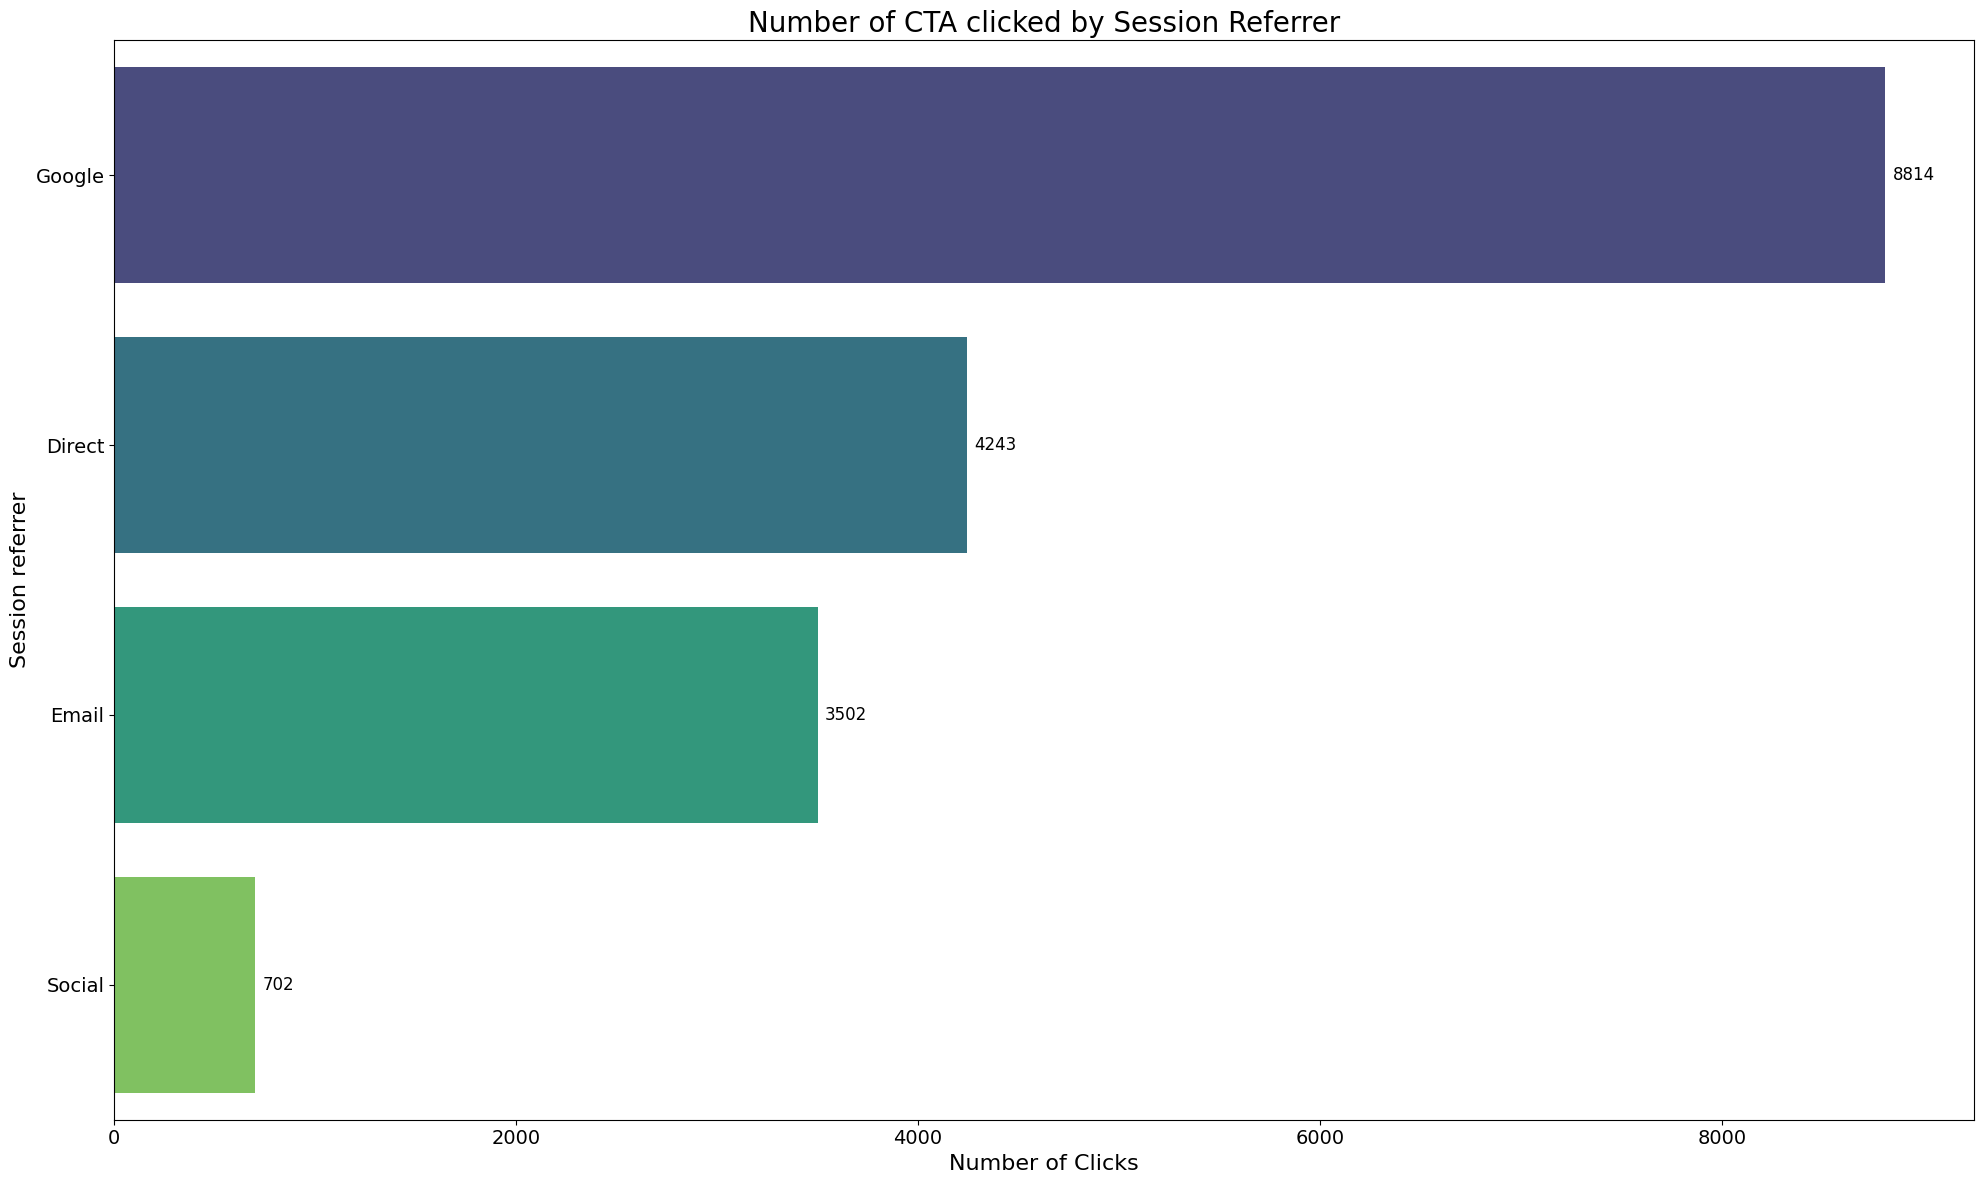

In [11]:
column_name = 'sessionReferrer'
# Get the order for the categories (highest count first)
ordered_categories = filtered_df[column_name].value_counts().index

fig, ax = plt.subplots(figsize=(20, 12))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y=column_name, data=filtered_df, order=ordered_categories, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of CTA clicked by Session Referrer", fontsize=20)
plt.xlabel("Number of Clicks", fontsize=16)
plt.ylabel("Session referrer", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = filtered_df[column_name].value_counts().loc[ordered_categories]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

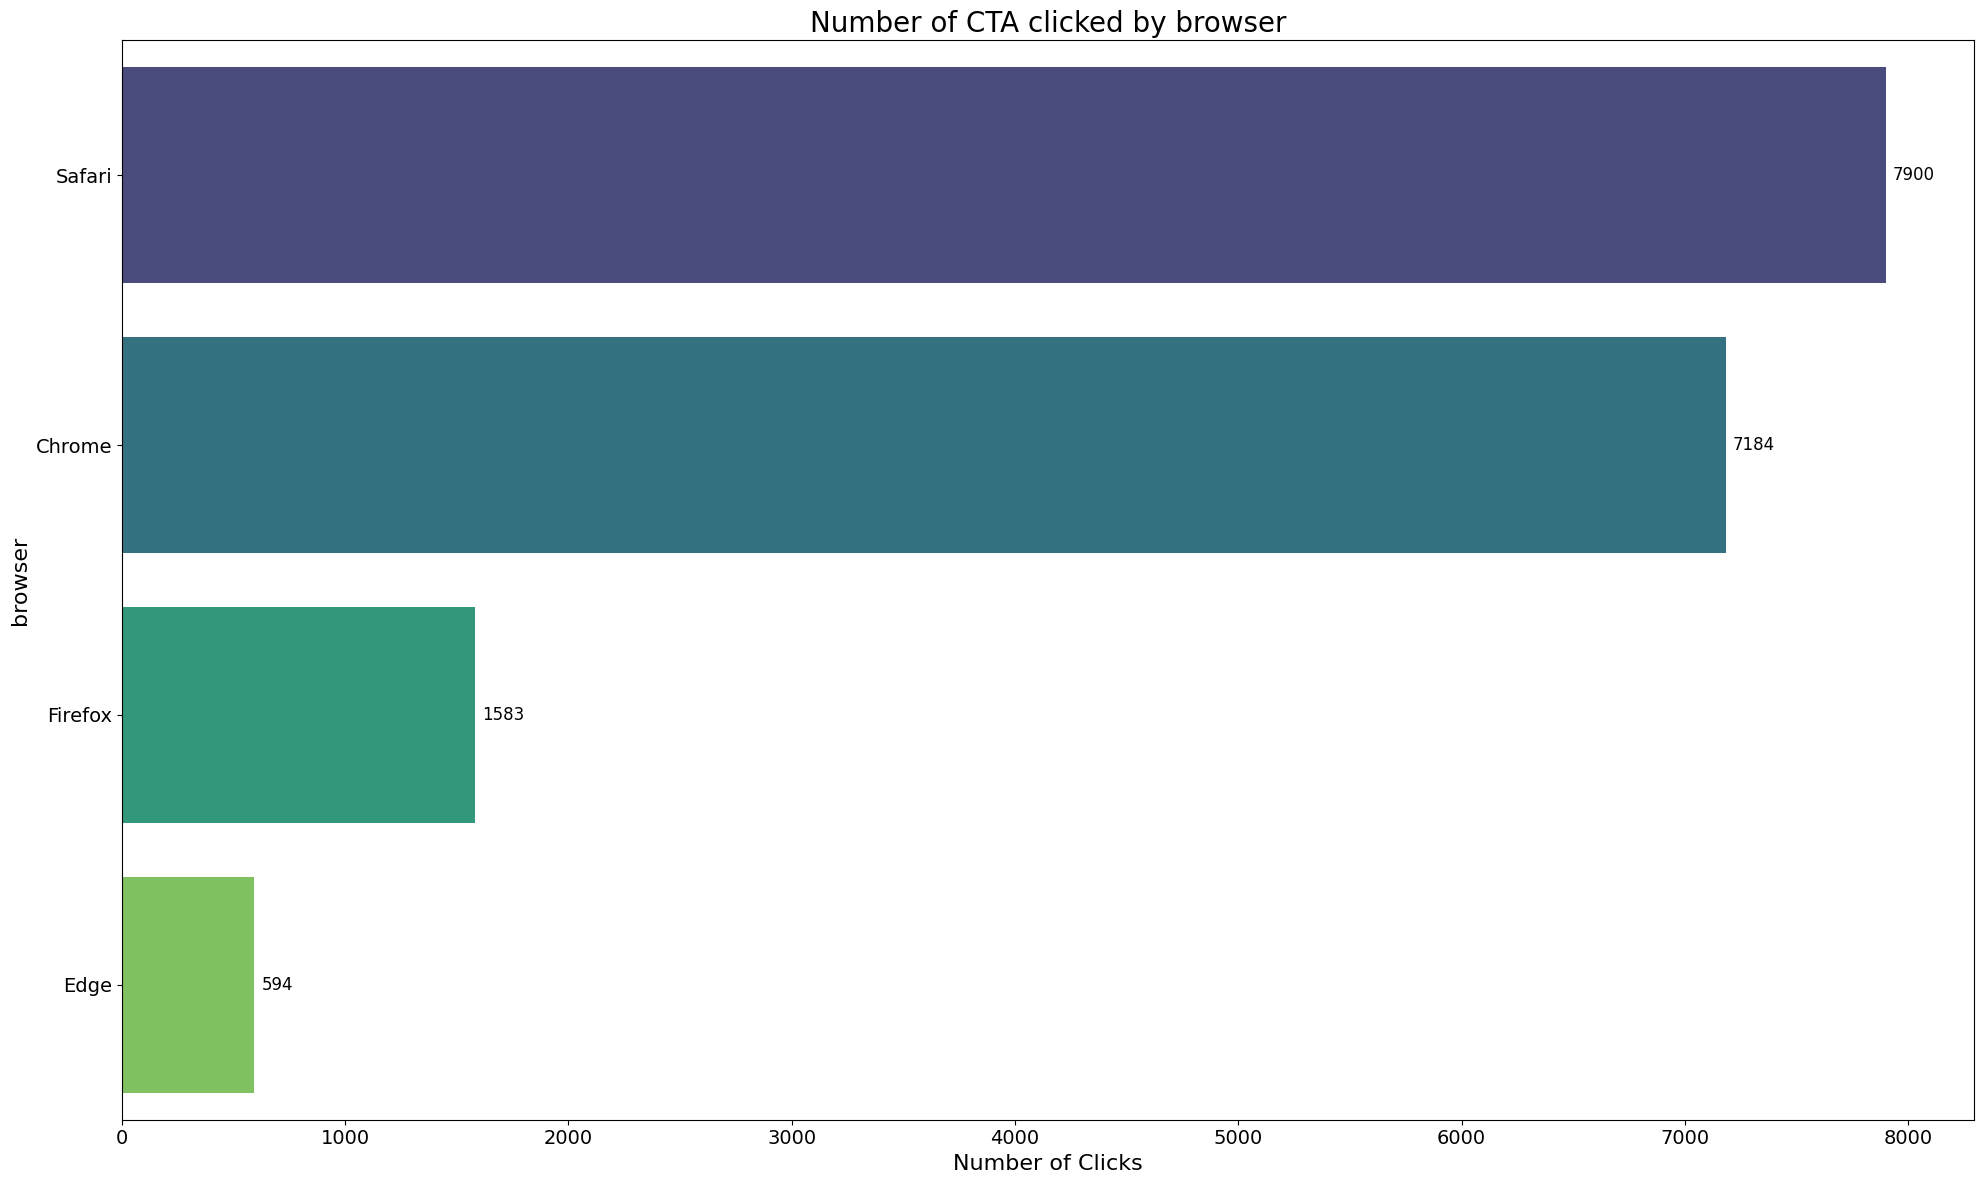

In [12]:
column_name = 'browser'

# Get the order for the categories (highest count first)
ordered_categories = filtered_df[column_name].value_counts().index

fig, ax = plt.subplots(figsize=(20, 12))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y=column_name, data=filtered_df, order=ordered_categories, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of CTA clicked by browser", fontsize=20)
plt.xlabel("Number of Clicks", fontsize=16)
plt.ylabel("browser", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = filtered_df[column_name].value_counts().loc[ordered_categories]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

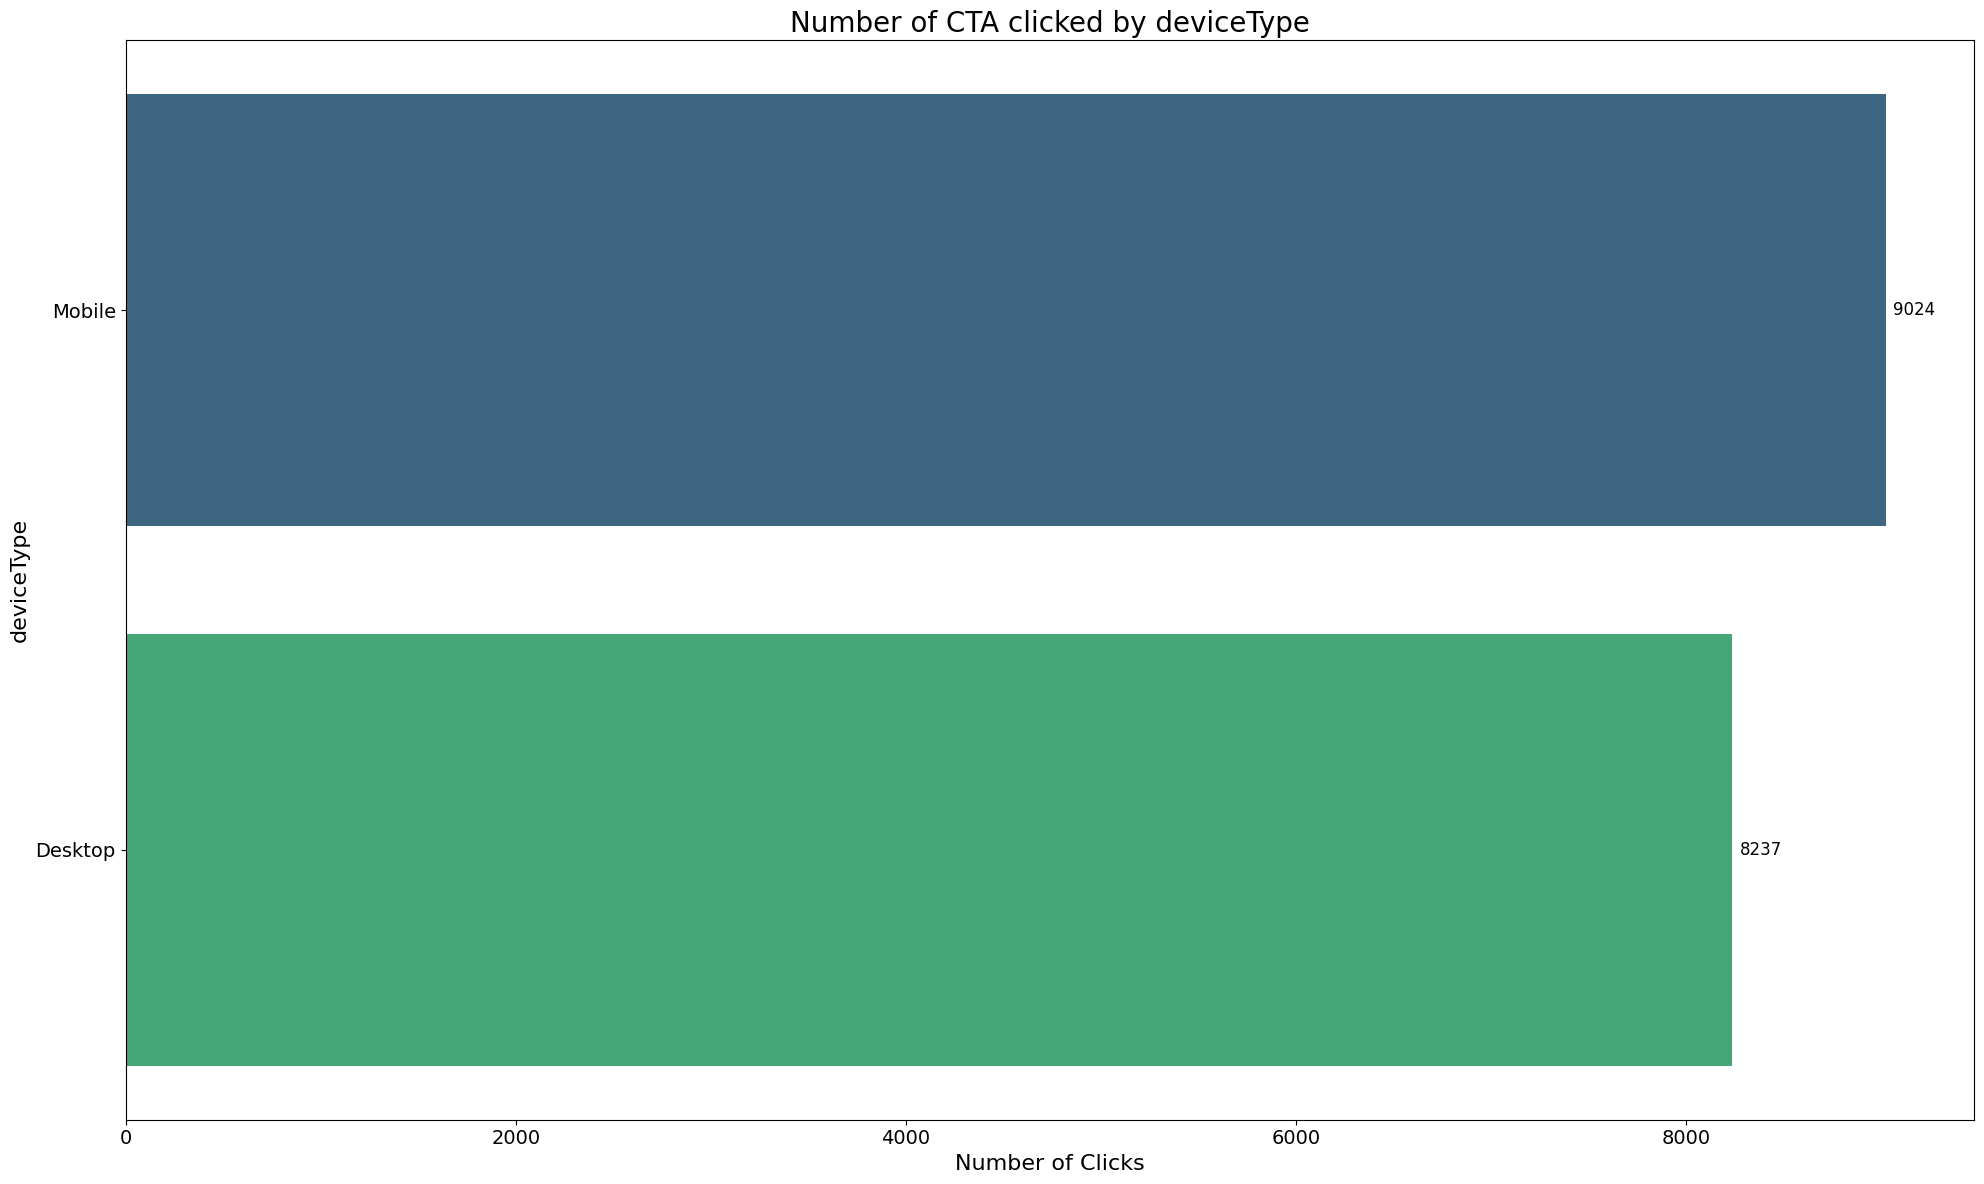

In [13]:
column_name = 'deviceType'

# Get the order for the categories (highest count first)
ordered_categories = filtered_df[column_name].value_counts().index

fig, ax = plt.subplots(figsize=(20, 12))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y=column_name, data=filtered_df, order=ordered_categories, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of CTA clicked by deviceType", fontsize=20)
plt.xlabel("Number of Clicks", fontsize=16)
plt.ylabel("deviceType", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = filtered_df[column_name].value_counts().loc[ordered_categories]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

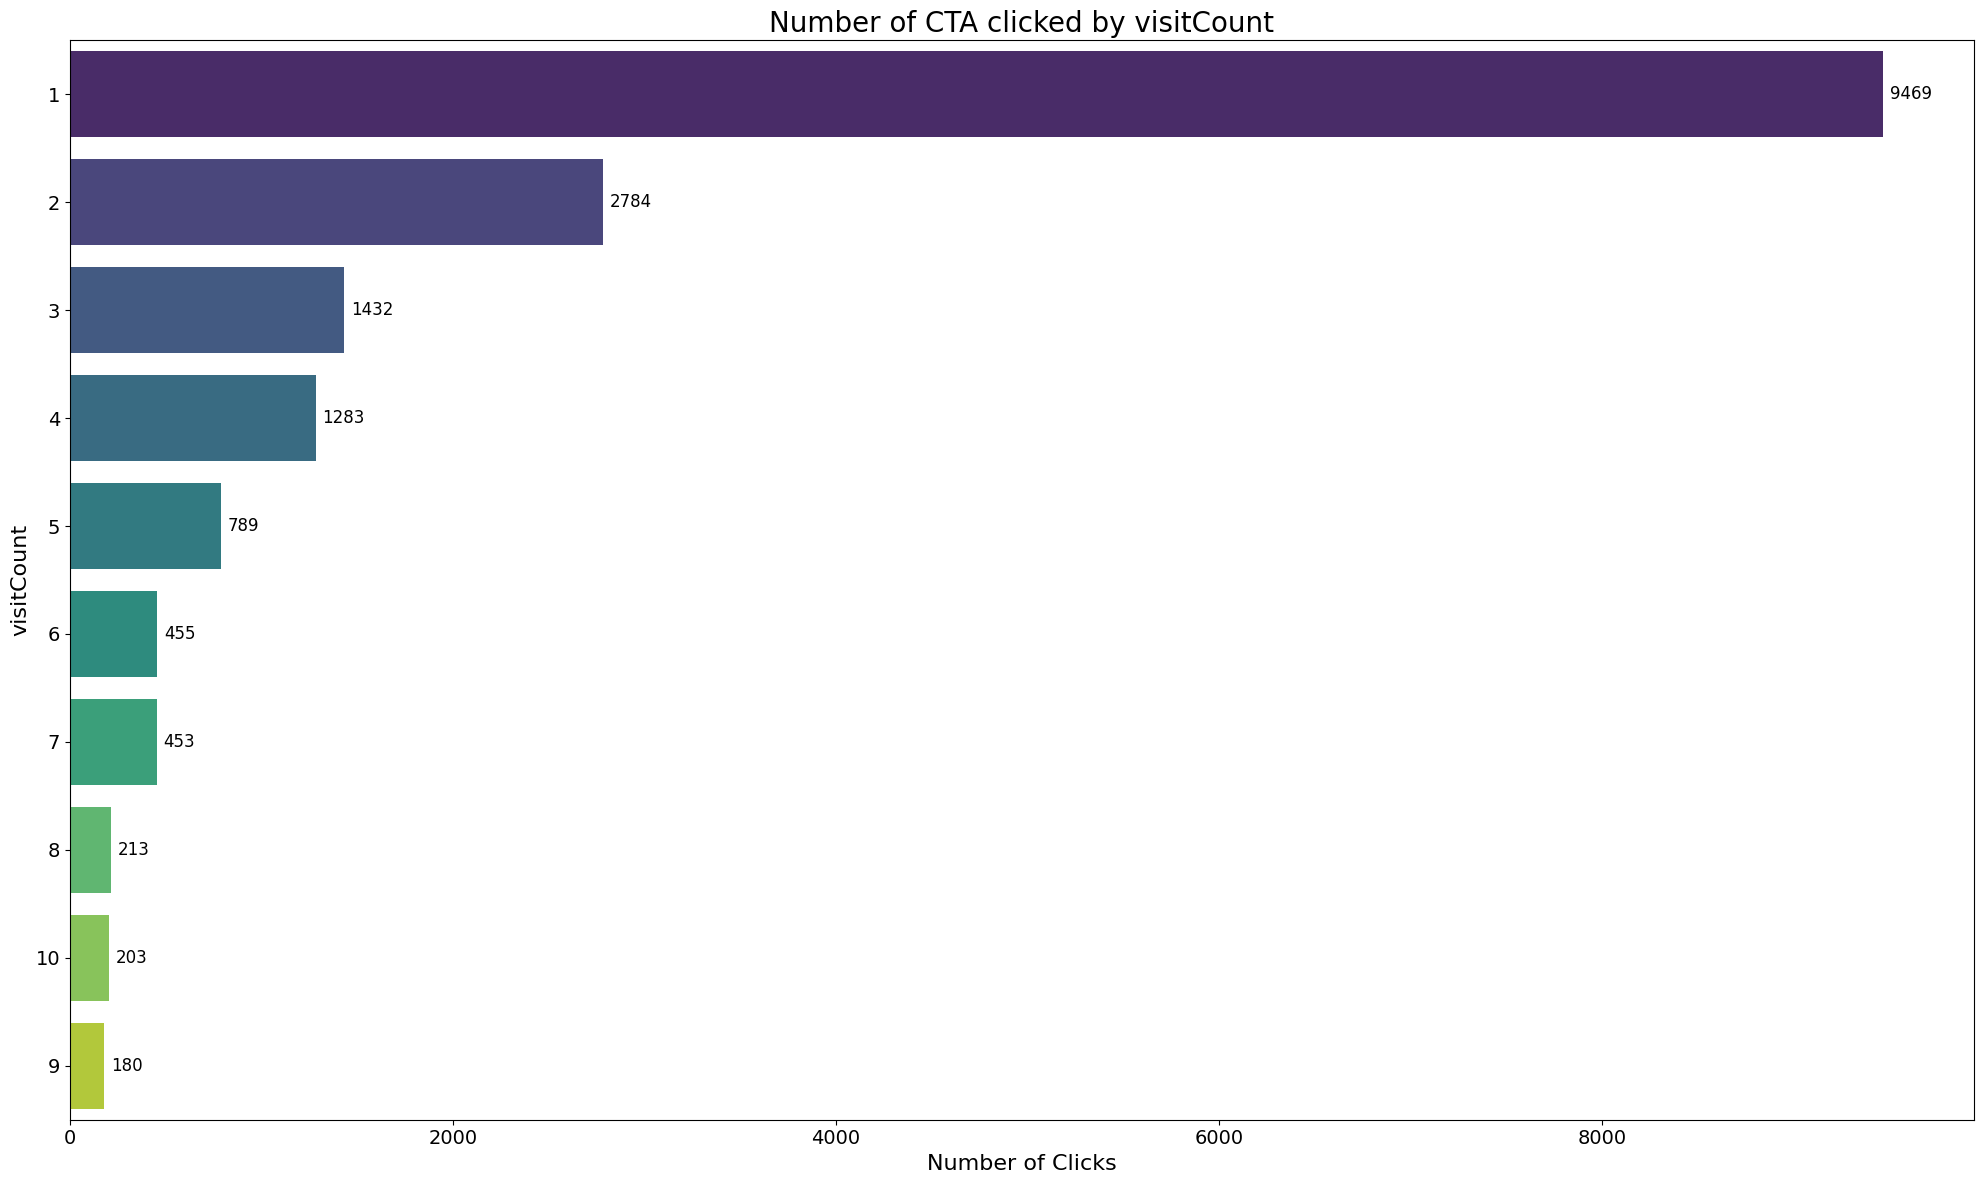

In [14]:
column_name = 'visitCount'

# Get the order for the categories (highest count first)
ordered_categories = filtered_df[column_name].value_counts().index

fig, ax = plt.subplots(figsize=(20, 12))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y=column_name, data=filtered_df, order=ordered_categories, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of CTA clicked by visitCount", fontsize=20)
plt.xlabel("Number of Clicks", fontsize=16)
plt.ylabel("visitCount", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = filtered_df[column_name].value_counts().loc[ordered_categories]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

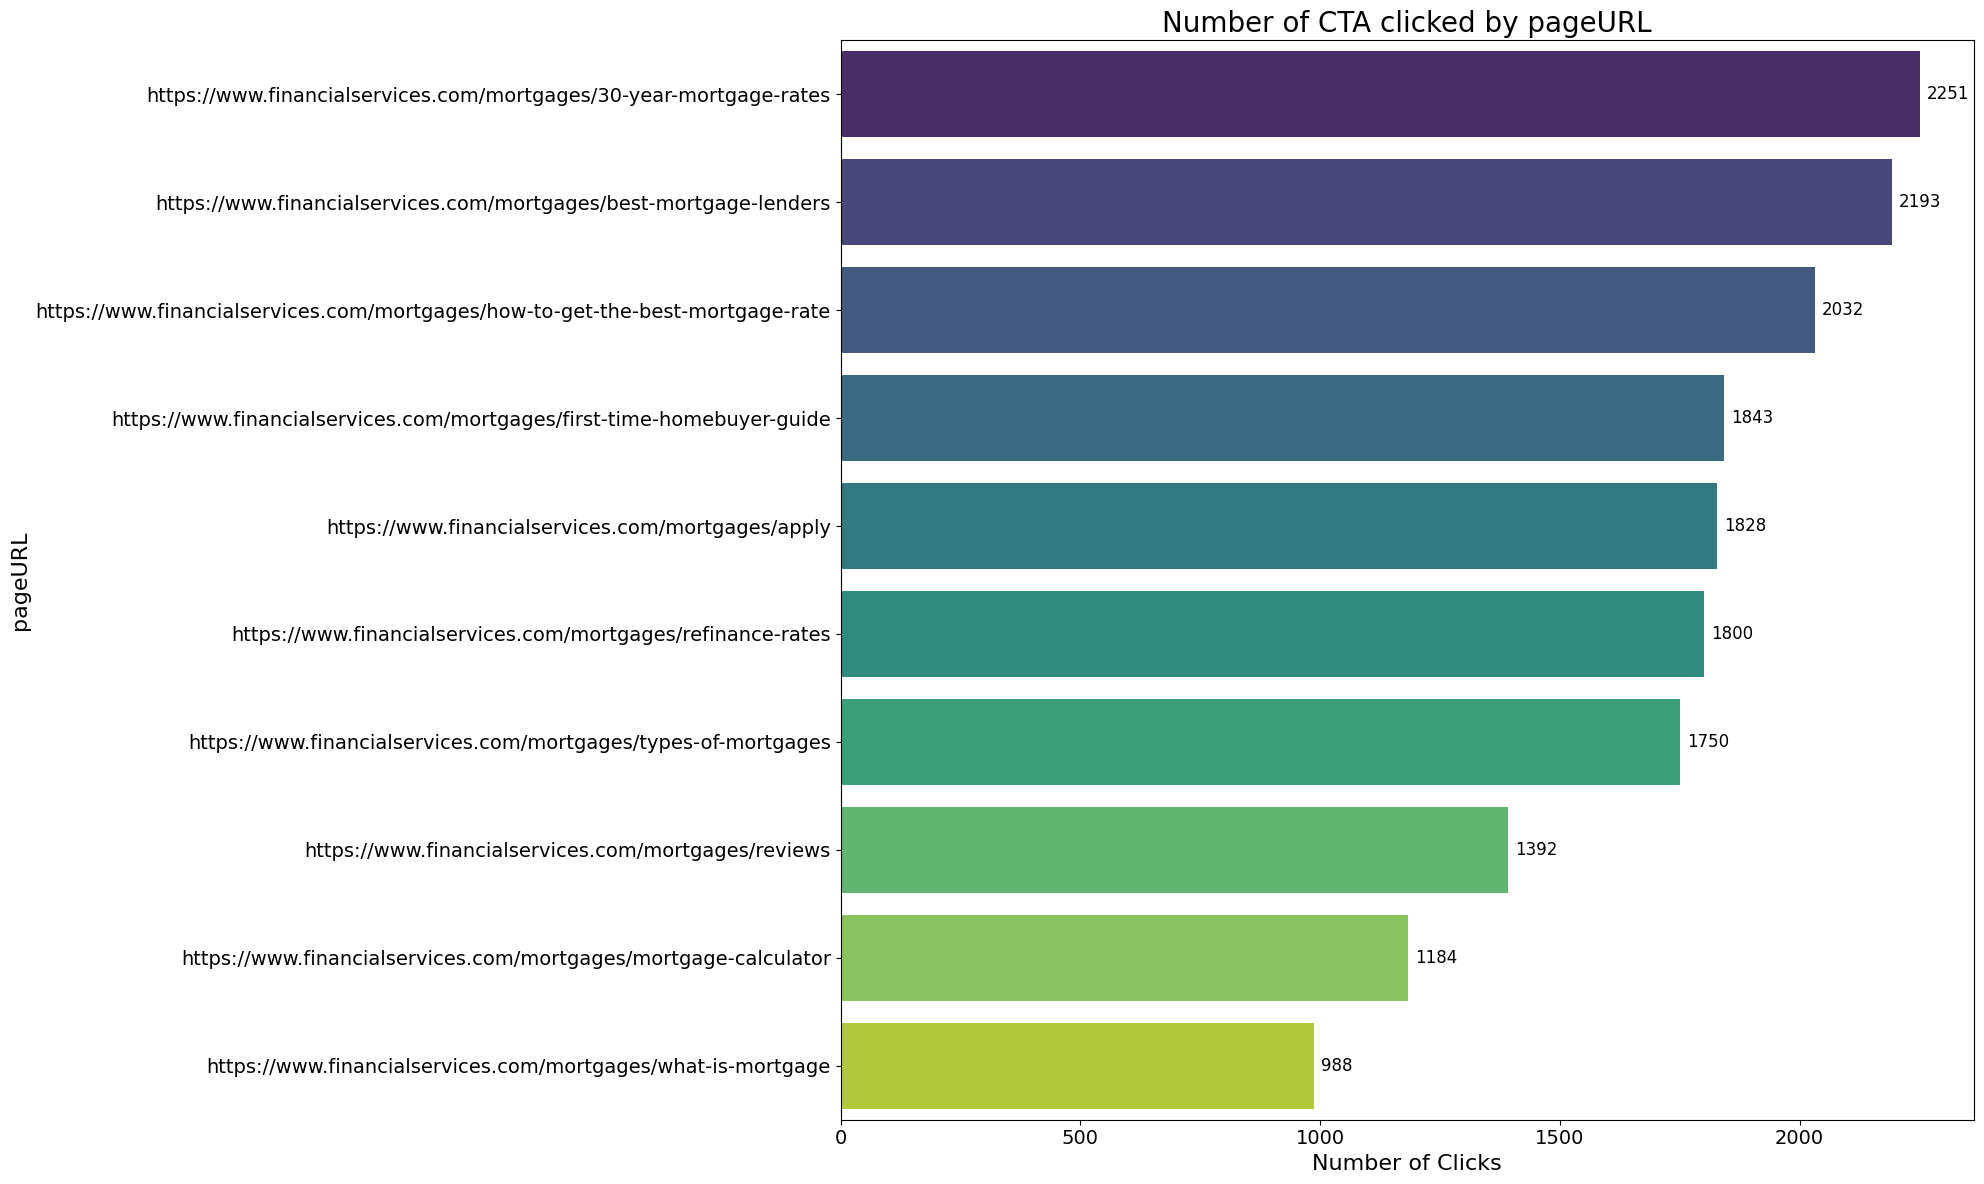

In [15]:
column_name = 'pageURL'

# Get the order for the categories (highest count first)
ordered_categories = filtered_df[column_name].value_counts().index

fig, ax = plt.subplots(figsize=(20, 12))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y=column_name, data=filtered_df, order=ordered_categories, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of CTA clicked by pageURL", fontsize=20)
plt.xlabel("Number of Clicks", fontsize=16)
plt.ylabel("pageURL", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = filtered_df[column_name].value_counts().loc[ordered_categories]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

### Here we have 10 different URLs, but if you can see, prefix of the URL is the same
- we will be removing 'https://www.financialservices.com/martgages' for cleaner look when we do feature engineering
and add feature page_name

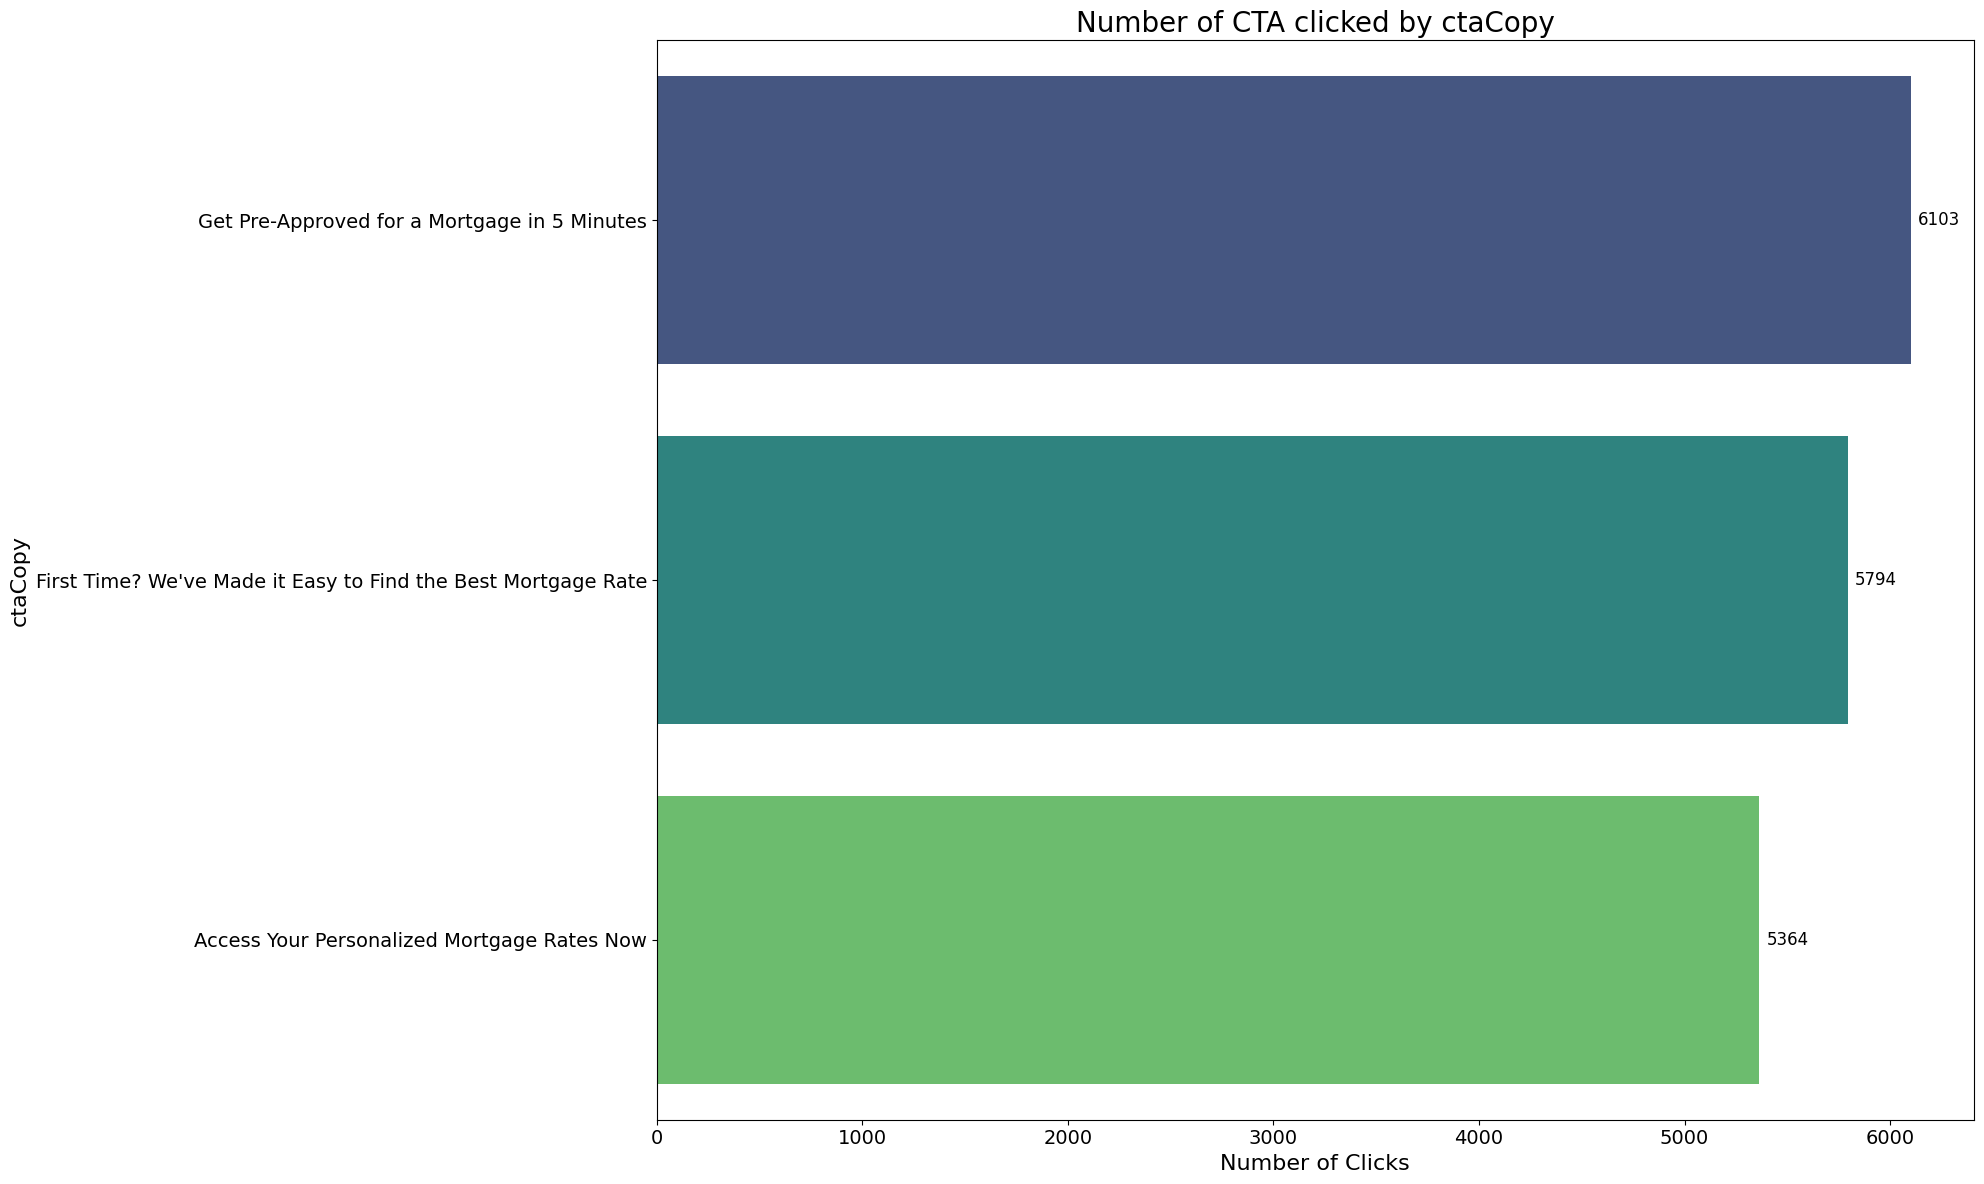

In [16]:
column_name = 'ctaCopy'

# Get the order for the categories (highest count first)
ordered_categories = filtered_df[column_name].value_counts().index

fig, ax = plt.subplots(figsize=(20, 12))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y=column_name, data=filtered_df, order=ordered_categories, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of CTA clicked by ctaCopy", fontsize=20)
plt.xlabel("Number of Clicks", fontsize=16)
plt.ylabel("ctaCopy", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = filtered_df[column_name].value_counts().loc[ordered_categories]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

### based on above explorations, we can say that "Get approved in 5 minutes" is the most clicked CTA
but there not not much difference in other ctaCOPY, we still have to do more exploration before we conclude

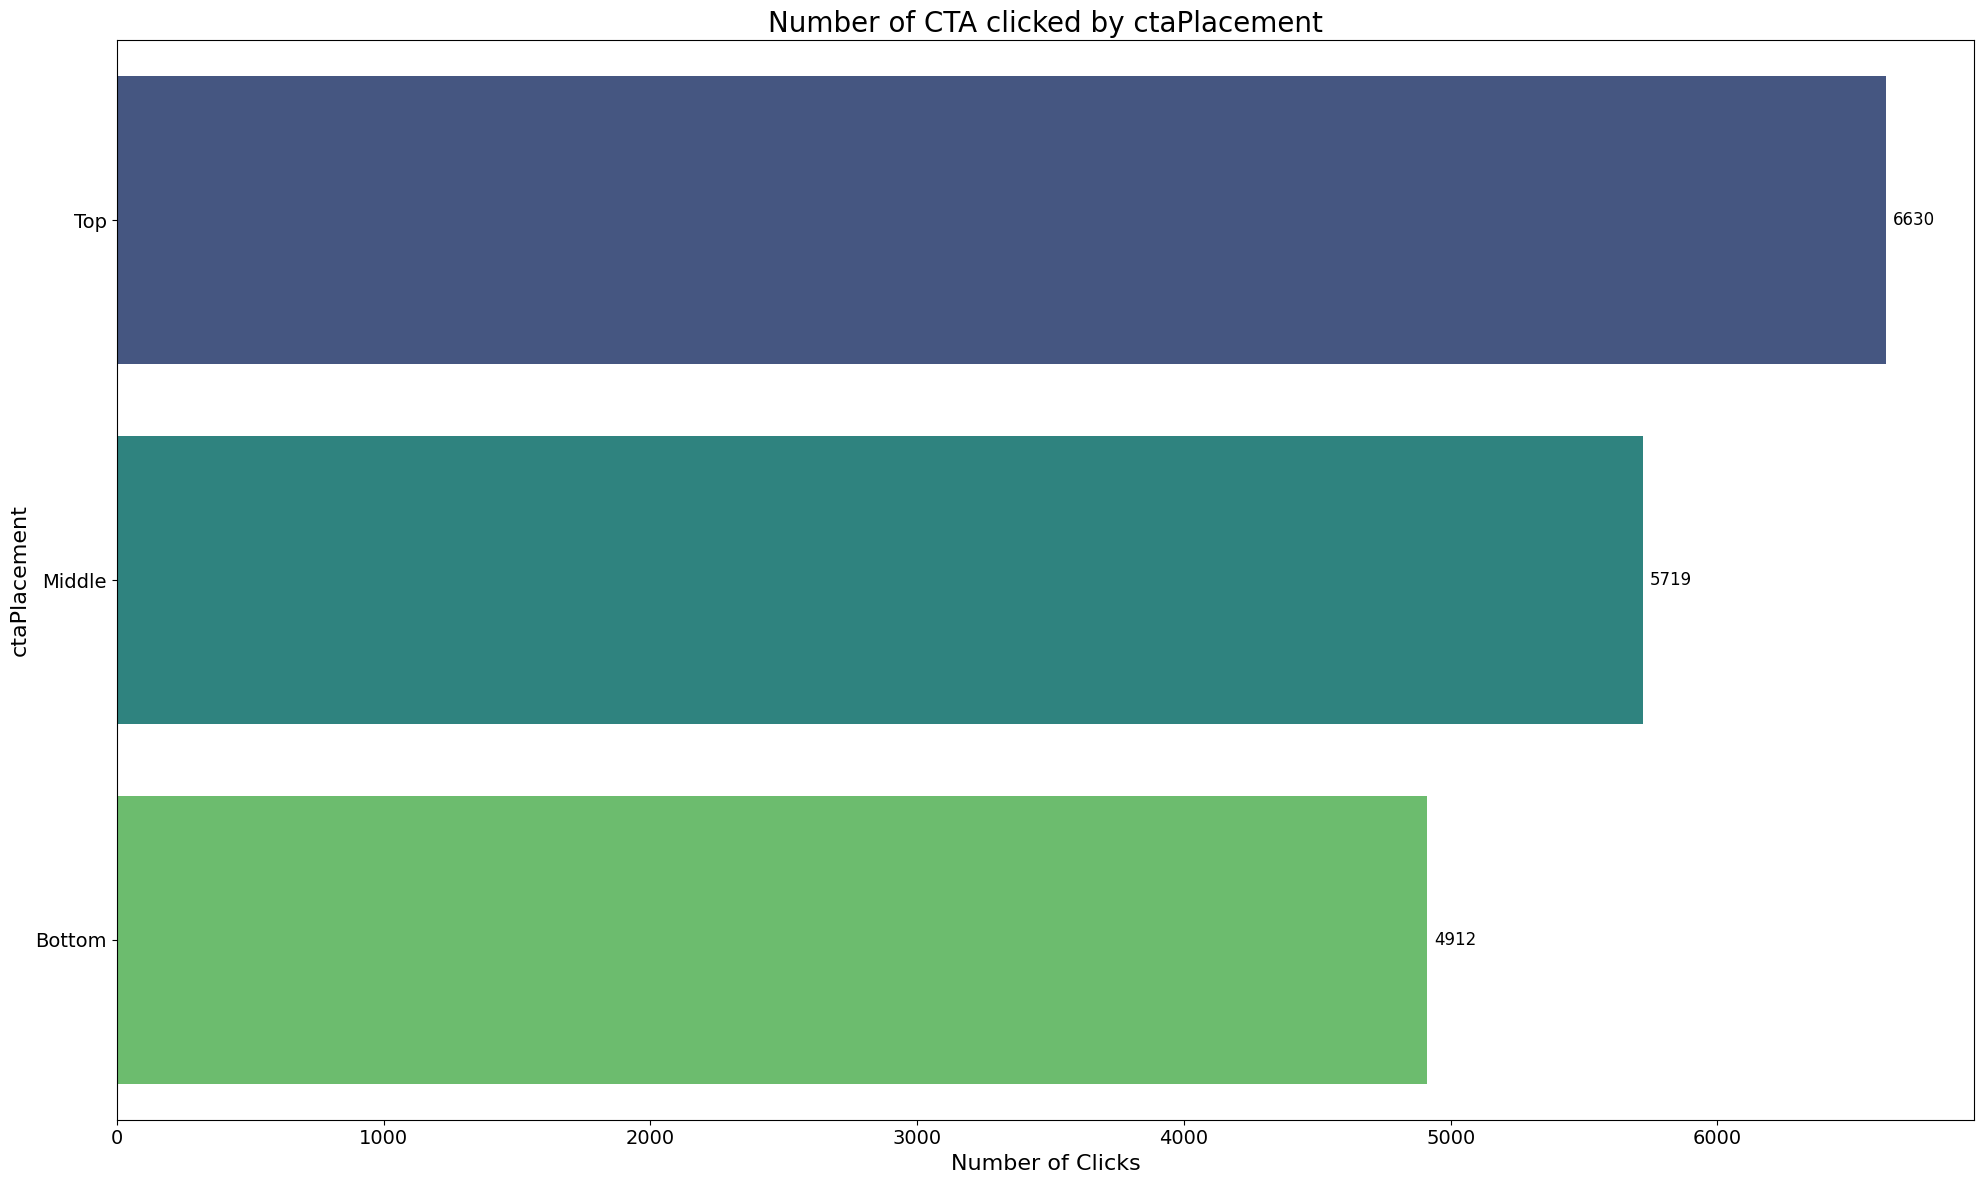

In [17]:
column_name = 'ctaPlacement'

# Get the order for the categories (highest count first)
ordered_categories = filtered_df[column_name].value_counts().index

fig, ax = plt.subplots(figsize=(20, 12))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y=column_name, data=filtered_df, order=ordered_categories, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of CTA clicked by ctaPlacement", fontsize=20)
plt.xlabel("Number of Clicks", fontsize=16)
plt.ylabel("ctaPlacement", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = filtered_df[column_name].value_counts().loc[ordered_categories]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

### Here TOP is mostly clicked 
but when we check there no significant changes in clicked CTA based on location


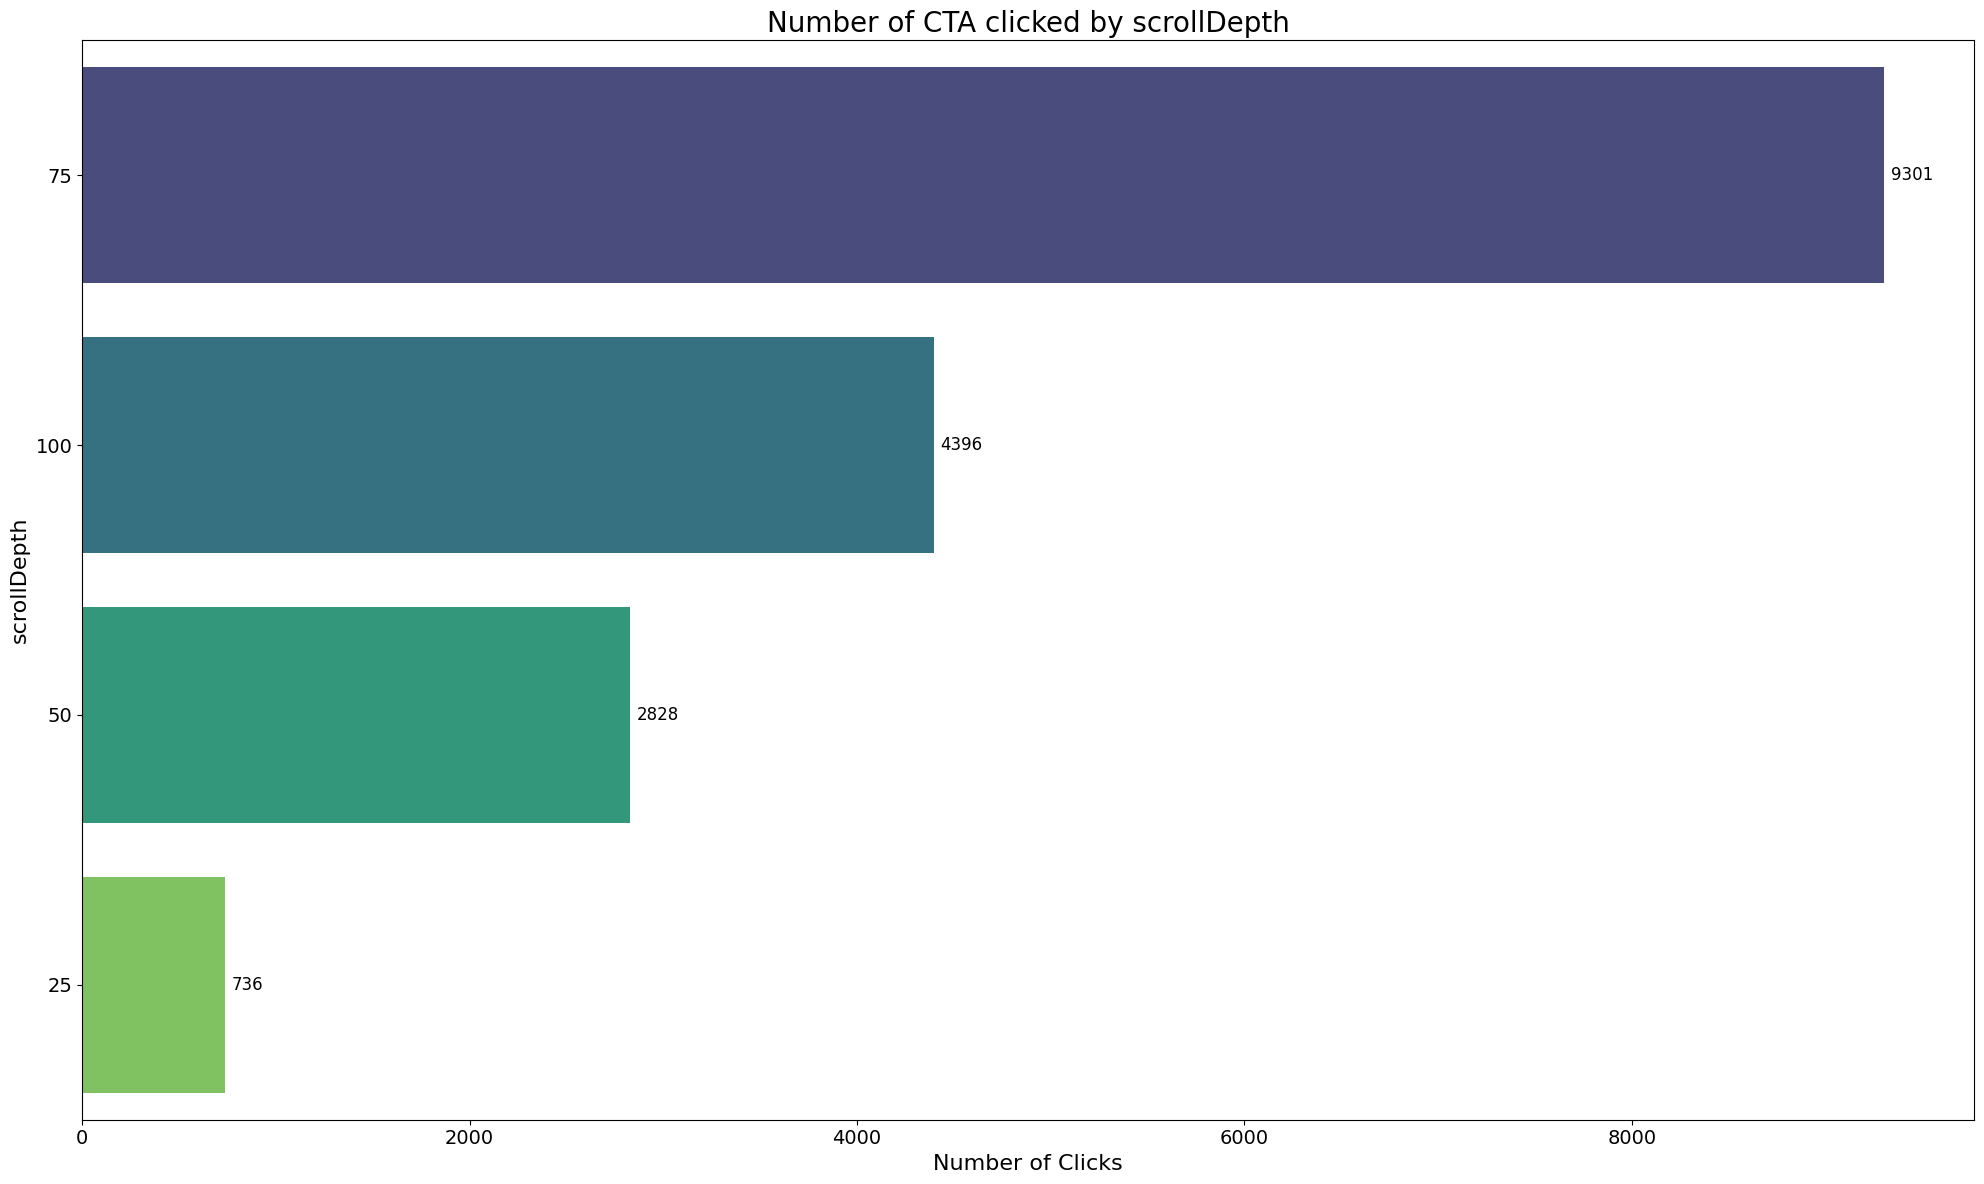

In [18]:
column_name = 'scrollDepth'

# Get the order for the categories (highest count first)
ordered_categories = filtered_df[column_name].value_counts().index

fig, ax = plt.subplots(figsize=(20, 12))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y=column_name, data=filtered_df, order=ordered_categories, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of CTA clicked by scrollDepth", fontsize=20)
plt.xlabel("Number of Clicks", fontsize=16)
plt.ylabel("scrollDepth", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = filtered_df[column_name].value_counts().loc[ordered_categories]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

- Problem statement is - we have to find the best combination for the cta Copy and cta Placement 
- We are since doing exploration, I have combined those 2 categories and created one more and then we will check against our clicked CTA

In [19]:
## we are still working on our filted df which has only clickedCTA = 1
filtered_df['cta_combination'] = filtered_df['ctaCopy'] + ' & ' + filtered_df['ctaPlacement']

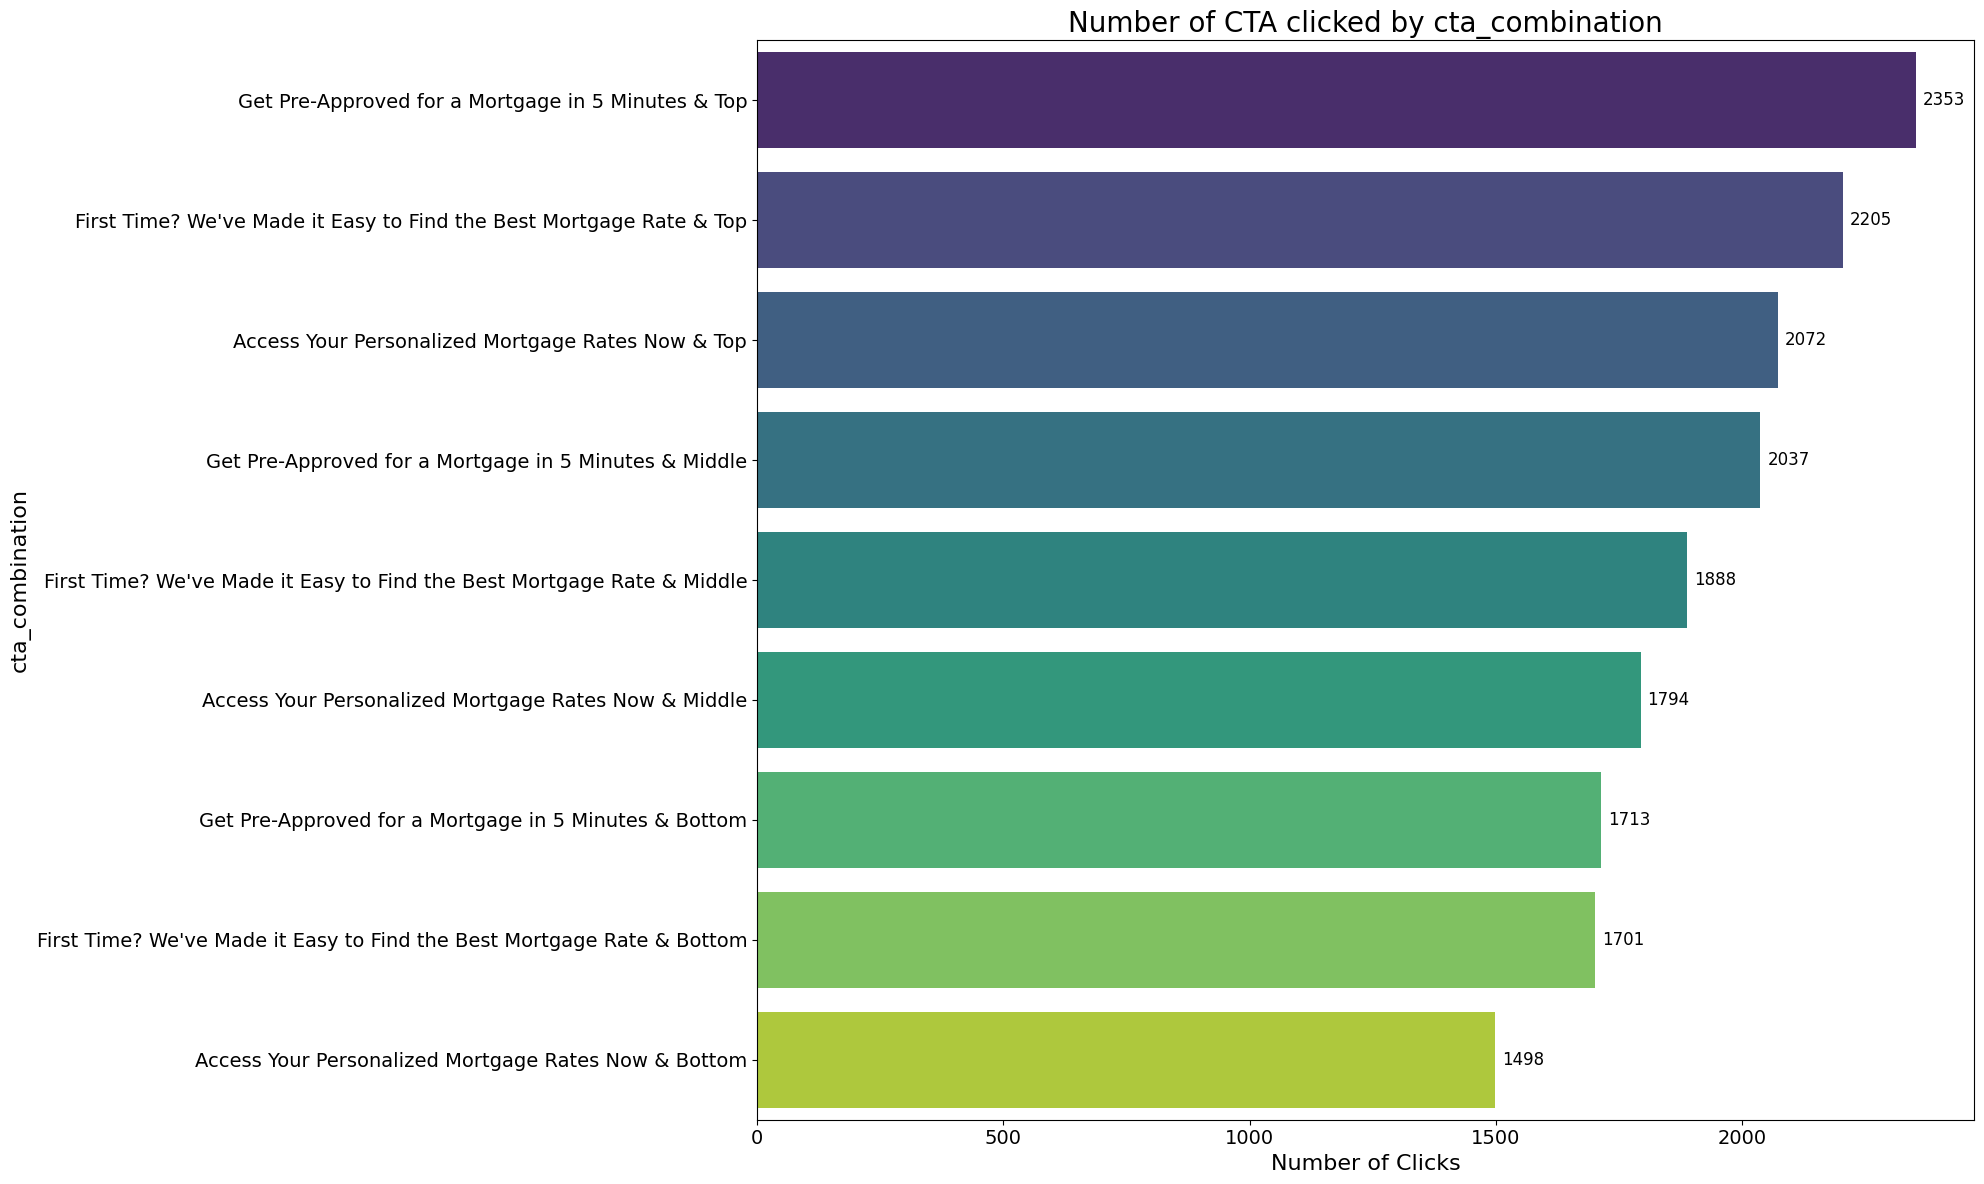

In [20]:
column_name = 'cta_combination'

# Get the order for the categories (highest count first)
ordered_categories = filtered_df[column_name].value_counts().index

fig, ax = plt.subplots(figsize=(20, 12))
plt.rcParams.update({'font.size': 12}) # Set a reasonable default font size

# Plot the countplot
sns.countplot(y=column_name, data=filtered_df, order=ordered_categories, ax=ax, palette='viridis')

plt.xticks(rotation=0) # Removed rotation for x-axis as it's now counts, usually not rotated
plt.title("Number of CTA clicked by cta_combination", fontsize=20)
plt.xlabel("Number of Clicks", fontsize=16)
plt.ylabel("cta_combination", fontsize=16)

# Adjust tick label font sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Get the actual counts in the same order as the bars for annotation
counts_for_annotation = filtered_df[column_name].value_counts().loc[ordered_categories]

# Add annotations to the bars
for p, count in zip(ax.patches, counts_for_annotation):
    # For horizontal bars:
    # x-coordinate is the width of the bar (the count value)
    # y-coordinate is the center of the bar
    x_val = p.get_width()
    y_val = p.get_y() + p.get_height() / 2

    # Annotate with the count
    # xytext shifts the text a little bit to the right of the bar
    # ha='left' aligns the text to its left edge at x_val + offset
    # va='center' vertically centers the text on the bar
    ax.annotate(f'{int(count)}', (x_val, y_val),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12) # Use a reasonable font size for annotations

plt.tight_layout() # Adjust layout to prevent labels/title from overlapping
plt.show()

Based on our above exploration, we can say that "Access your personalized Mortgage rates now and locaiton Bottom"
is less clicked compared to other.
Also there are not much difference in line 3 and 4, also 7 and 8

- End goal, we have to provide best combination that increase clicked CTA
- Then schedule appointment


we can also do some further analysis regarding selected mortgage (mortgage variations) and revenue
I am keeping that for future scope

Text(0, 0.5, 'Frequency')

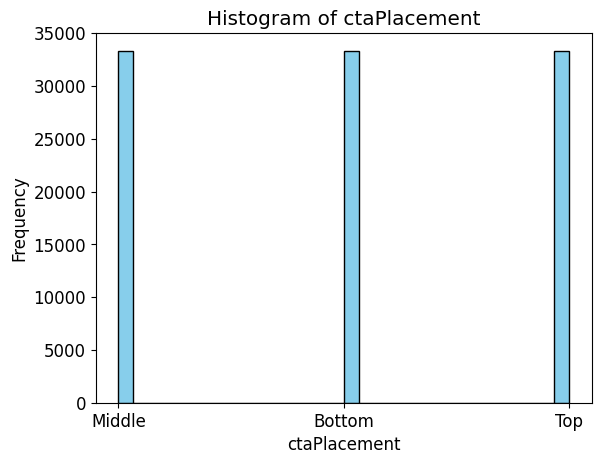

In [21]:
### for the histogram, we will be using the Whole dataset, not the filtered one

# Histogram for 'ctaPlacement'
column_name = 'ctaPlacement'
plot_data = df[column_name]
plt.hist(plot_data, bins=30, color='skyblue', edgecolor='black')

# Set plot title and labels
plt.title(f'Histogram of {column_name}')
plt.xlabel(column_name)
plt.ylabel('Frequency')

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000.]),
 [Text(0.0, 0, '0'),
  Text(5000.0, 0, '5000'),
  Text(10000.0, 0, '10000'),
  Text(15000.0, 0, '15000'),
  Text(20000.0, 0, '20000'),
  Text(25000.0, 0, '25000'),
  Text(30000.0, 0, '30000'),
  Text(35000.0, 0, '35000'),
  Text(40000.0, 0, '40000')])

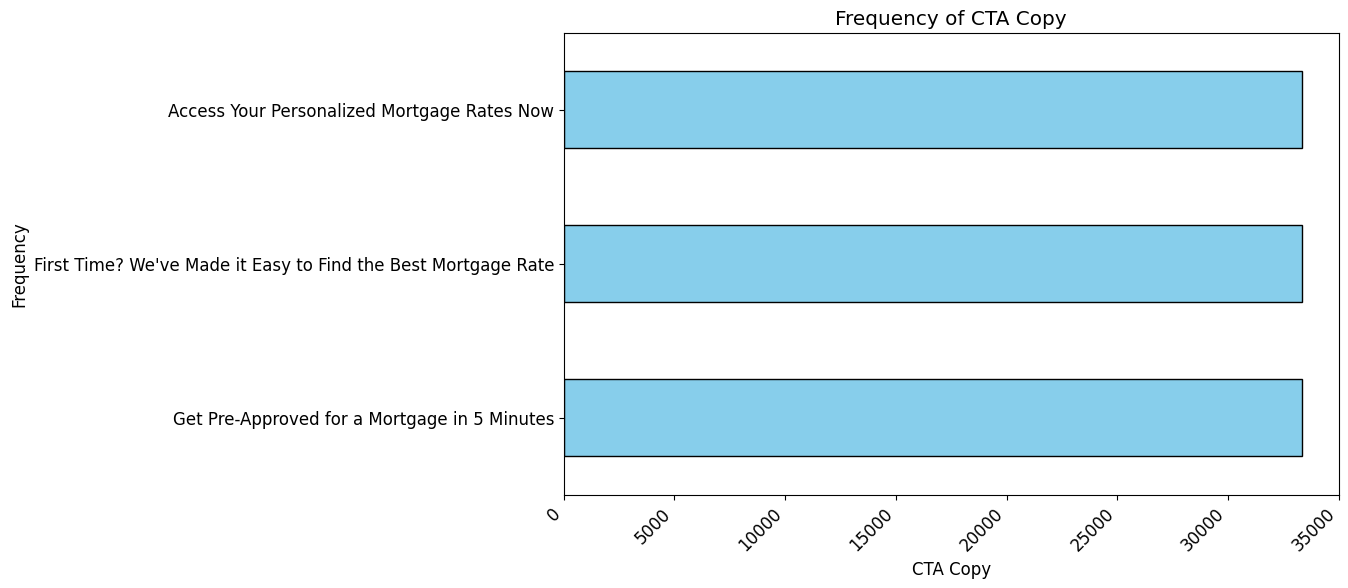

In [22]:
# Histogram for 'ctaCopy' since, Text is too long, we will use bar plot instead of histogram
column_name = 'ctaCopy'

# Use value_counts() to get the frequency of each ctaCopy
plot_data = df[column_name].value_counts()

# Create a bar chart (kind='bar') instead of a histogram
plt.figure(figsize=(10, 6))
plot_data.plot(kind='barh', color='skyblue', edgecolor='black')

# Set plot title and labels
plt.title('Frequency of CTA Copy')
plt.xlabel('CTA Copy')
plt.ylabel('Frequency')

# Add this line to rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

Based on our exploration, we can say that, our target variable has imbalance data but our find cta copy and cta placement are balanced

# <a id='fourth'></a> Feature Engineering
In this section, we are generating new relavant columns and removing unwanted columns then we will do Train_Test_Split

In [23]:
## This will show the columns of the dataframe
print("Columns in the DataFrame:")
df.columns

Columns in the DataFrame:


Index(['date', 'userId', 'sessionReferrer', 'browser', 'deviceType',
       'estimatedAnnualIncome', 'estimatedPropertyType', 'visitCount',
       'pageURL', 'ctaCopy', 'ctaPlacement', 'editorialSnippet', 'scrollDepth',
       'clickedCTA', 'submittedForm', 'scheduledAppointment',
       'mortgageVariation', 'revenue'],
      dtype='object')

### Columns to be deleted
date: since whole csv belongs to same month

userId: since it is unique for each user, and we are building a model.

editorialSnippet: since it is not useful for our analysis

In [24]:
def delete_columns(df):
    """
    Delete specified columns from the DataFrame.
    """
    columns_to_drop = ['date', 'userId','editorialSnippet']
    df.drop(columns=columns_to_drop, inplace=True)
    return df

In [25]:
def generate_cta_combination(df):
    """
    Generate a new column 'cta_combination' by combining 'ctaCopy' and 'ctaPlacement'.
    """
    df['cta_combination'] = df['ctaCopy'] + ' & ' + df['ctaPlacement']
    return df

In [26]:
def delete_ctaCopy_and_ctaPlacement(df):
    """
    Delete 'ctaCopy' and 'ctaPlacement' columns from the DataFrame.
    """
    df.drop(columns=['ctaCopy', 'ctaPlacement'], inplace=True)
    return df

In [27]:
def generate_page_name_and_delete_page_url(df):
    """
    Shorten the 'pageURL' column by extracting the domain name.
    """
    df['pageName'] = df['pageURL'].str.split('/').str[-1]
    df.drop(columns=['pageURL'], inplace=True)  # Drop the original 'pageURL' column
    return df

In [28]:
# Define numerical and categorical features
numerical_features_zero_impute = ['estimatedAnnualIncome', 'revenue']
categorical_features_onehot = ['sessionReferrer', 'browser', 'deviceType', 'estimatedPropertyType', 'scrollDepth',
                                'cta_combination', 'pageName']
special_impute_feature = 'mortgageVariation'

In [29]:
## Below is the complete pipeline which can help us for training and testing data generation


def generate_pipeline(numerical_features_zero_impute, categorical_features_onehot, special_impute_feature) -> Pipeline:
    """
    Generate a complete preprocessing pipeline for the dataset.
    This pipeline includes:
    - Generating a new column 'cta_combination'
    - Generating a new column 'pageName' from 'pageURL' and deleting 'pageURL'
    - Deleting specified columns
    - Preprocessing numerical features (imputation and scaling)
    - Preprocessing categorical features (one-hot encoding)
    - Preprocessing a special feature with imputation and one-hot encoding
    """
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())
    ])

    # A single pipeline for the special mortgage feature: impute, then one-hot encode
    mortgage_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='no_appointment')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            # Apply the numerical pipeline to the numerical features
            ('numerical_pipe', numerical_transformer, numerical_features_zero_impute),
            # Apply the mortgage pipeline to the special feature
            ('mortgage_pipe', mortgage_transformer, [special_impute_feature]),
            # One-hot encode other categorical features
            ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_onehot)
        ],
        remainder='drop'  # Use 'drop' to prevent unhandled columns from causing errors
    )

    full_pipeline = Pipeline(steps=[
        ('generate_cta_combination', FunctionTransformer(generate_cta_combination, validate=False)),
        ('generate_page_name_and_delete_page_url', FunctionTransformer(generate_page_name_and_delete_page_url, validate=False)),
        ('delete_columns', FunctionTransformer(delete_columns, validate=False)),  # Ensure this deletes original features if they're not used
        ('final_preprocess', preprocessor)
    ])
    return full_pipeline

# <a id='fifth'></a> Data Splitting

In [30]:
X = df.drop('clickedCTA', axis=1)
y = df['clickedCTA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# You can optionally print the shapes to confirm the split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("\nFraud proportion in original data:", y.mean())
print("Fraud proportion in y_train:", y_train.mean())
print("Fraud proportion in y_test:", y_test.mean())

Shape of X_train: (80000, 17)
Shape of X_test: (20000, 17)
Shape of y_train: (80000,)
Shape of y_test: (20000,)

Fraud proportion in original data: 0.17261
Fraud proportion in y_train: 0.1726125
Fraud proportion in y_test: 0.1726


- So far, are looking good, now we are running our pipeline which will handle all the imputations and onehotencoding

In [31]:
pipeline = generate_pipeline(numerical_features_zero_impute, categorical_features_onehot, special_impute_feature)

X_train = pipeline.fit_transform(X_train)
print("Transformed X_train shape:", X_train.shape)

X_test = pipeline.transform(X_test)
print("Transformed X_test shape:", X_test.shape)

# Create the artifacts directory if it doesn't exist
if not os.path.exists('artifacts'):
    os.makedirs('artifacts')

# Define the file path
pipeline_path = 'artifacts/pipeline.joblib'

# Save the fitted pipeline
joblib.dump(pipeline, pipeline_path)

print(f"Pipeline saved successfully to {pipeline_path}")

Transformed X_train shape: (80000, 45)
Transformed X_test shape: (20000, 45)
Pipeline saved successfully to artifacts/pipeline.joblib


# <a id='sixth'></a> Model Training

In [32]:
### This function will be used to print the score of the model
### It will print the accuracy score, classification report and confusion matrix
def print_score(true, pred, pred_proba, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Log Loss: {log_loss(true, pred_proba) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Log Loss: {log_loss(true, pred_proba) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

## Logistic regression - with L1 and L2 using optuna

In [33]:
### for demonstration, I am using optuna in below code
### then after I will be using randomized search cv for hyperparameter tuning

def objective(trial, X_train, y_train):
    """
    Objective function for Optuna to minimize Log Loss.
    """
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'C': trial.suggest_loguniform('C', 0.001, 10.0),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga'])
    }
    
    # Handle incompatible parameter combinations for LogisticRegression
    if param['penalty'] == 'l1' and param['solver'] == 'saga':
        pass
    elif param['penalty'] == 'l1' and param['solver'] != 'liblinear':
        raise optuna.exceptions.TrialPruned()
    
    # Use cross-validation with stratified folds
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)
    
    lr_clf = LogisticRegression(**param, random_state=42)

    # The scoring is set to 'neg_log_loss' to be maximized by Optuna (minimizes log loss)
    # The pipeline is passed directly to cross_val_score
    score = cross_val_score(lr_clf, X_train, y_train, cv=cv, scoring='neg_log_loss', n_jobs=-1)
    return score.mean()

In [34]:
# Create a study object and run the optimization
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(direction='minimize') # Direction is 'minimize' for log loss
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)  # Using a small number of trials for demonstration

best_params = study.best_params
best_score = study.best_value

print("\n--- Optuna Optimization Results ---")
print(f"Best Parameters: {best_params}")
print(f"Best Log Loss Score: {-best_score:.4f}") # Print the positive log loss

[I 2025-08-11 08:36:55,385] A new study created in memory with name: no-name-45a436a3-36c2-49a4-876f-237d74340b4c


Starting Optuna hyperparameter optimization...


[I 2025-08-11 08:37:02,614] Trial 0 finished with value: -0.3252927502377256 and parameters: {'penalty': 'l2', 'C': 0.0124934253955533, 'solver': 'saga'}. Best is trial 0 with value: -0.3252927502377256.
[I 2025-08-11 08:37:06,997] Trial 1 finished with value: -0.3236943382395808 and parameters: {'penalty': 'l1', 'C': 0.02518343708843846, 'solver': 'liblinear'}. Best is trial 0 with value: -0.3252927502377256.
[I 2025-08-11 08:37:12,556] Trial 2 finished with value: -0.32317296055112876 and parameters: {'penalty': 'l2', 'C': 0.053442428093042546, 'solver': 'saga'}. Best is trial 0 with value: -0.3252927502377256.
[I 2025-08-11 08:37:13,152] Trial 3 finished with value: -0.32244366663757645 and parameters: {'penalty': 'l2', 'C': 0.2751688610148827, 'solver': 'liblinear'}. Best is trial 0 with value: -0.3252927502377256.
[I 2025-08-11 08:37:16,051] Trial 4 finished with value: -0.32218095363573257 and parameters: {'penalty': 'l1', 'C': 5.563342665986668, 'solver': 'liblinear'}. Best is t


--- Optuna Optimization Results ---
Best Parameters: {'penalty': 'l1', 'C': 0.002996373019401691, 'solver': 'saga'}
Best Log Loss Score: 0.3443


In [35]:
# Train the final model with the best parameters found by Optuna
lr_clf = LogisticRegression(**best_params, random_state=42)
lr_clf.fit(X_train, y_train)

# Make predictions and print scores
y_train_pred = lr_clf.predict(X_train)
y_test_pred = lr_clf.predict(X_test)

y_train_pred_proba = lr_clf.predict_proba(X_train)[:, 1]
y_test_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred, y_train_pred_proba, train=True)
print_score(y_test, y_test_pred, y_test_pred_proba, train=False)

Train Result:
Log Loss: 33.71%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.875867      1.000000  0.882737      0.937933      0.897294
recall         1.000000      0.320660  0.882737      0.660330      0.882737
f1-score       0.933826      0.485606  0.882737      0.709716      0.856458
support    66191.000000  13809.000000  0.882737  80000.000000  80000.000000
_______________________________________________
Confusion Matrix: 
 [[66191     0]
 [ 9381  4428]]

Test Result:
Log Loss: 33.91%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.875046     1.000000   0.88185      0.937523      0.896613
recall         1.000000     0.315469   0.88185      0.657735      0.881850
f1-score       0.933360     0.479630   0.88185      0.706495      0.855046
support    16548.

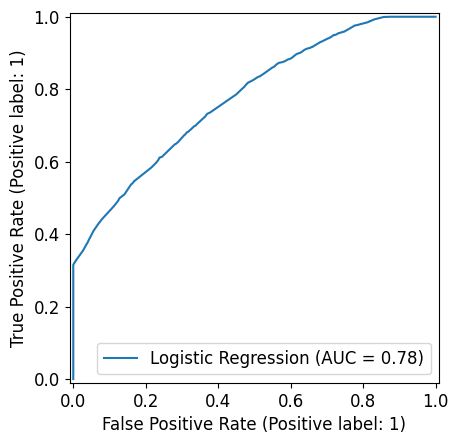

In [36]:
disp = RocCurveDisplay.from_estimator(lr_clf, X_test, y_test, name='Logistic Regression')

## Random Forest classifier

In [37]:
# I am using randomized search cv for hyperparameter tuning instead of optuna

param_grid = dict(
    n_estimators=stats.randint(10, 100),
    max_depth=stats.randint(10, 15),
    min_samples_split=stats.randint(1, 10),
    min_samples_leaf=stats.randint(1, 10),
    class_weight=[None, 'balanced']
)

rf_clf = RandomForestClassifier(random_state=42)
rf_cv = RandomizedSearchCV(
    rf_clf, param_grid, cv=3, n_iter=3, 
    scoring='neg_log_loss', n_jobs=-1, verbose=1, random_state=42
)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print(f"Best Parameters: {best_params}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'class_weight': None, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 39}


In [38]:
rf_clf = RandomForestClassifier(**best_params, random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions and print scores
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

y_train_pred_proba = rf_clf.predict_proba(X_train)[:, 1]
y_test_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred, y_train_pred_proba, train=True)
print_score(y_test, y_test_pred, y_test_pred_proba, train=False)

Train Result:
Log Loss: 29.85%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.875867      1.000000  0.882737      0.937933      0.897294
recall         1.000000      0.320660  0.882737      0.660330      0.882737
f1-score       0.933826      0.485606  0.882737      0.709716      0.856458
support    66191.000000  13809.000000  0.882737  80000.000000  80000.000000
_______________________________________________
Confusion Matrix: 
 [[66191     0]
 [ 9381  4428]]

Test Result:
Log Loss: 31.78%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.875046     1.000000   0.88185      0.937523      0.896613
recall         1.000000     0.315469   0.88185      0.657735      0.881850
f1-score       0.933360     0.479630   0.88185      0.706495      0.855046
support    16548.

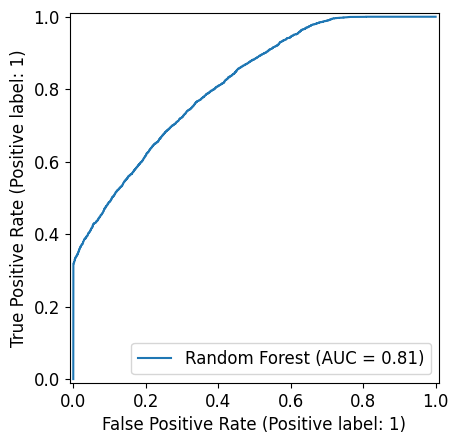

In [39]:
disp = RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, name='Random Forest')

## XB Boost

In [40]:
param_grid = dict(
    n_estimators=stats.randint(10, 50),
    max_depth=stats.randint(1, 5),
    learning_rate=stats.uniform(0, 1)
)

xgb_clf = XGBClassifier(use_label_encoder=False, random_state=42)
xgb_cv = RandomizedSearchCV(
    xgb_clf, param_grid, cv=3, n_iter=3, 
    scoring='neg_log_loss', n_jobs=-1, verbose=1, random_state=42
)
xgb_cv.fit(X_train, y_train)

best_params = xgb_cv.best_params_
print(f"Best Parameters: {best_params}")


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'learning_rate': np.float64(0.7319939418114051), 'max_depth': 1, 'n_estimators': 30}


In [41]:

xgb_clf = XGBClassifier(**best_params, random_state=42)
xgb_clf.fit(X_train, y_train)

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

y_train_pred_proba = xgb_clf.predict_proba(X_train)[:, 1]
y_test_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred, y_train_pred_proba, train=True)
print_score(y_test, y_test_pred, y_test_pred_proba, train=False)

Train Result:
Log Loss: 32.37%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.875867      1.000000  0.882737      0.937933      0.897294
recall         1.000000      0.320660  0.882737      0.660330      0.882737
f1-score       0.933826      0.485606  0.882737      0.709716      0.856458
support    66191.000000  13809.000000  0.882737  80000.000000  80000.000000
_______________________________________________
Confusion Matrix: 
 [[66191     0]
 [ 9381  4428]]

Test Result:
Log Loss: 32.60%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.875046     1.000000   0.88185      0.937523      0.896613
recall         1.000000     0.315469   0.88185      0.657735      0.881850
f1-score       0.933360     0.479630   0.88185      0.706495      0.855046
support    16548.

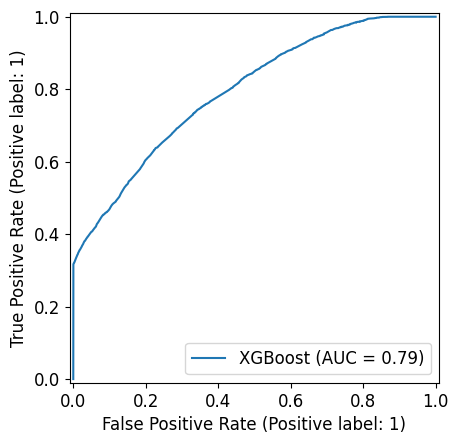

In [42]:
disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test, name='XGBoost')

## Light GBM

In [43]:
# Define parameter distributions for LightGBM
lgbm_param_grid = dict(
    n_estimators=stats.randint(10, 50),          # Number of boosting rounds
    learning_rate=stats.loguniform(0.01, 0.2),   # Step size shrinkage
    num_leaves=stats.randint(2, 25),             # Max tree leaves for base learners
    max_depth=stats.randint(5, 15),              # Max tree depth
    min_child_samples=stats.randint(1, 10),      # Minimum data in a child
    reg_alpha=stats.loguniform(1e-3, 10.0),      # L1 regularization
    reg_lambda=stats.loguniform(1e-3, 10.0),     # L2 regularization
)

# Initialize LightGBM Classifier
lgb_clf = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1) # verbose=-1 to suppress verbose output during training

# Initialize RandomizedSearchCV
lgb_cv = RandomizedSearchCV(
    lgb_clf,
    lgbm_param_grid,
    cv=3,                 # Number of cross-validation folds
    n_iter=3,             # Number of parameter settings that are sampled (adjust as needed for thoroughness)
    scoring='neg_log_loss',    # Metric to optimize
    n_jobs=-1,            # Use all available CPU cores
    verbose=1,            # Controls the verbosity: 0 = silent, 1 = progress bar, 2 = verbose
    random_state=42       # For reproducibility of sampling
)

# Fit RandomizedSearchCV to the training data
lgb_cv.fit(X_train, y_train)

# Get the best parameters
best_params_lgbm = lgb_cv.best_params_
print(f"\nBest LightGBM Parameters: {best_params_lgbm}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best LightGBM Parameters: {'learning_rate': np.float64(0.16637391143003455), 'max_depth': 6, 'min_child_samples': 5, 'n_estimators': 42, 'num_leaves': 13, 'reg_alpha': np.float64(0.27964859516062457), 'reg_lambda': np.float64(0.0010672476836323724)}


In [44]:
# Train the model with the best parameters 
lgb_clf = lgb.LGBMClassifier(**best_params, random_state=42)
lgb_clf.fit(X_train, y_train)

# Make predictions and print scores
y_train_pred = lgb_clf.predict(X_train)
y_test_pred = lgb_clf.predict(X_test)

y_train_pred_proba = lgb_clf.predict_proba(X_train)[:, 1]
y_test_pred_proba = lgb_clf.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred, y_train_pred_proba, train=True)
print_score(y_test, y_test_pred, y_test_pred_proba, train=False)

Train Result:
Log Loss: 32.36%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.875867      1.000000  0.882737      0.937933      0.897294
recall         1.000000      0.320660  0.882737      0.660330      0.882737
f1-score       0.933826      0.485606  0.882737      0.709716      0.856458
support    66191.000000  13809.000000  0.882737  80000.000000  80000.000000
_______________________________________________
Confusion Matrix: 
 [[66191     0]
 [ 9381  4428]]

Test Result:
Log Loss: 32.60%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.875046     1.000000   0.88185      0.937523      0.896613
recall         1.000000     0.315469   0.88185      0.657735      0.881850
f1-score       0.933360     0.479630   0.88185      0.706495      0.855046
support    16548.

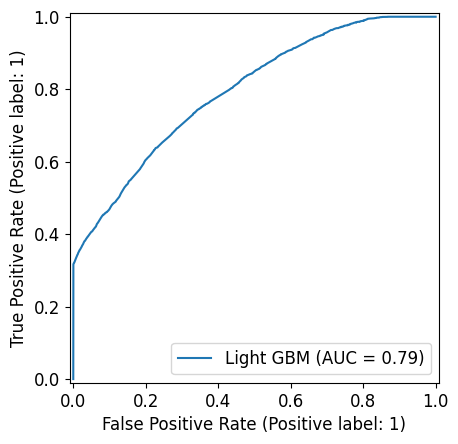

In [45]:
disp = RocCurveDisplay.from_estimator(lgb_clf, X_test, y_test, name='Light GBM')

## Comparing models using ROC AUC curve

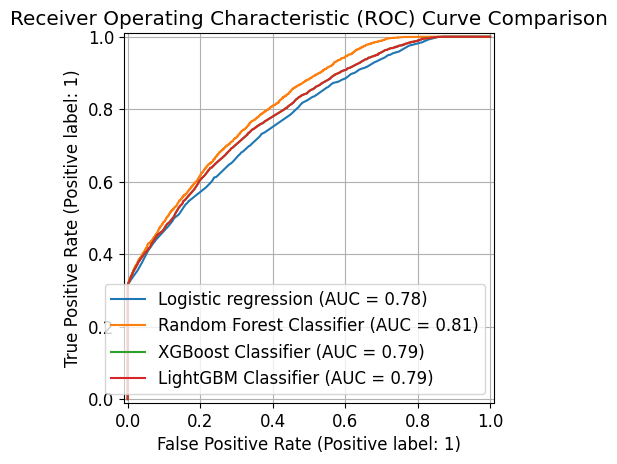


ROC AUC curves plotted successfully using RocCurveDisplay.from_estimator.


In [46]:
models_to_plot = [
    (lr_clf, 'Logistic regression'),
    (rf_clf, 'Random Forest Classifier'),
    (xgb_clf, 'XGBoost Classifier'),
    (lgb_clf, 'LightGBM Classifier')
]

# Check if the models_to_plot list is empty
if not models_to_plot:
    print("Error: 'models_to_plot' list is empty. Please add your trained model objects and their names.")
else:
    # Initialize the plot with the first model
    # RocCurveDisplay.from_estimator returns a display object.
    # We pass 'name' here for the legend label.
    first_model, first_model_name = models_to_plot[0]
    disp = RocCurveDisplay.from_estimator(first_model, X_test, y_test, name=first_model_name)

    # Loop through the rest of the models and plot their ROC curves on the same axes.
    # We use 'ax=disp.ax_' to plot on the existing axes.
    for model, name in models_to_plot[1:]:
        RocCurveDisplay.from_estimator(model, X_test, y_test, ax=disp.ax_, name=name)

    # Add a title to the plot
    plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
    
    # Add a grid for better readability (optional)
    plt.grid(True)
    
    # Display the plot
    plt.show()

    print("\nROC AUC curves plotted successfully using RocCurveDisplay.from_estimator.")

### Now we will apply SMOTE 

We will do same training one more time with over sampled data and find out which one are working better

In [47]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Shape of X_train after SMOTE:", X_train_smote.shape)
print("Shape of y_train after SMOTE:", y_train_smote.shape)

# --- Check the class distribution ---
print("Class distribution after SMOTE:")
print(Counter(y_train_smote))

Shape of X_train after SMOTE: (132382, 45)
Shape of y_train after SMOTE: (132382,)
Class distribution after SMOTE:
Counter({0: 66191, 1: 66191})


In [48]:
# Create a study object and run the optimization
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(direction='minimize') # Direction is 'minimize' for log loss
study.optimize(lambda trial: objective(trial, X_train_smote, y_train_smote), n_trials=10)  # Using a small number of trials for demonstration

best_params = study.best_params
best_score = study.best_value

print("\n--- Optuna Optimization Results ---")
print(f"Best Parameters: {best_params}")
print(f"Best Log Loss Score: {-best_score:.4f}") # Print the positive log loss

[I 2025-08-11 08:38:43,990] A new study created in memory with name: no-name-2fb625ee-195a-47ab-8ee2-b04ec2f80455


Starting Optuna hyperparameter optimization...


[I 2025-08-11 08:38:45,816] Trial 0 finished with value: -0.49380424990472327 and parameters: {'penalty': 'l1', 'C': 0.04577349273482071, 'solver': 'saga'}. Best is trial 0 with value: -0.49380424990472327.
[I 2025-08-11 08:38:52,787] Trial 1 finished with value: -0.49521251718125026 and parameters: {'penalty': 'l2', 'C': 0.020130970923113445, 'solver': 'saga'}. Best is trial 1 with value: -0.49521251718125026.
[I 2025-08-11 08:38:59,188] Trial 2 finished with value: -0.49359367468893317 and parameters: {'penalty': 'l1', 'C': 0.09419669948496813, 'solver': 'liblinear'}. Best is trial 1 with value: -0.49521251718125026.
[I 2025-08-11 08:39:00,303] Trial 3 finished with value: -0.4948254696506728 and parameters: {'penalty': 'l2', 'C': 0.027299191459110903, 'solver': 'liblinear'}. Best is trial 1 with value: -0.49521251718125026.
[I 2025-08-11 08:39:01,087] Trial 4 finished with value: -0.4963233407118075 and parameters: {'penalty': 'l2', 'C': 0.011096283634944887, 'solver': 'liblinear'}.


--- Optuna Optimization Results ---
Best Parameters: {'penalty': 'l2', 'C': 0.011096283634944887, 'solver': 'liblinear'}
Best Log Loss Score: 0.4963


In [49]:
# Train the final model with the best parameters found by Optuna
lr_clf_smote = LogisticRegression(**best_params, random_state=42)
lr_clf_smote.fit(X_train_smote, y_train_smote)

# Make predictions and print scores
y_train_pred = lr_clf_smote.predict(X_train_smote)
y_test_pred = lr_clf_smote.predict(X_test)

y_train_pred_proba = lr_clf_smote.predict_proba(X_train_smote)[:, 1]
y_test_pred_proba = lr_clf_smote.predict_proba(X_test)[:, 1]

print_score(y_train_smote, y_train_pred, y_train_pred_proba, train=True)
print_score(y_test, y_test_pred, y_test_pred_proba, train=False)

Train Result:
Log Loss: 49.52%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.685752      0.727904   0.70468       0.706828       0.706828
recall         0.755631      0.653729   0.70468       0.704680       0.704680
f1-score       0.718998      0.688826   0.70468       0.703912       0.703912
support    66191.000000  66191.000000   0.70468  132382.000000  132382.000000
_______________________________________________
Confusion Matrix: 
 [[50016 16175]
 [22920 43271]]

Test Result:
Log Loss: 48.33%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.911290     0.357761    0.7387      0.634526      0.815751
recall         0.757977     0.646292    0.7387      0.702134      0.738700
f1-score       0.827593     0.460570    0.7387      0.644081      0.764245
support

In [50]:
# Lets run the same experiment with SMOTE

param_grid = dict(
    n_estimators=stats.randint(10, 100),
    max_depth=stats.randint(10, 15),
    min_samples_split=stats.randint(1, 10),
    min_samples_leaf=stats.randint(1, 10),
    class_weight=[None, 'balanced']
)

_rf_clf = RandomForestClassifier(random_state=42)
rf_cv = RandomizedSearchCV(
    _rf_clf, param_grid, cv=3, n_iter=3,
    scoring='neg_log_loss', n_jobs=-1, verbose=1, random_state=42
)
rf_cv.fit(X_train_smote, y_train_smote)
best_params = rf_cv.best_params_
print(f"Best Parameters: {best_params}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'class_weight': None, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 39}


In [51]:
# Train the model with the best parameters 
rf_clf_smote = RandomForestClassifier(**best_params, random_state=42)
rf_clf_smote.fit(X_train_smote, y_train_smote)

# Make predictions and print scores
y_train_pred = rf_clf_smote.predict(X_train_smote)
y_test_pred = rf_clf_smote.predict(X_test)

y_train_pred_proba = rf_clf_smote.predict_proba(X_train_smote)[:, 1]
y_test_pred_proba = rf_clf_smote.predict_proba(X_test)[:, 1]

print_score(y_train_smote, y_train_pred, y_train_pred_proba, train=True)
print_score(y_test, y_test_pred, y_test_pred_proba, train=False)

Train Result:
Log Loss: 39.82%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.794367      0.894762  0.837251       0.844564       0.844564
recall         0.910094      0.764409  0.837251       0.837251       0.837251
f1-score       0.848301      0.824465  0.837251       0.836383       0.836383
support    66191.000000  66191.000000  0.837251  132382.000000  132382.000000
_______________________________________________
Confusion Matrix: 
 [[60240  5951]
 [15594 50597]]

Test Result:
Log Loss: 42.29%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.893818     0.520262    0.8339      0.707040      0.829343
recall         0.906998     0.483488    0.8339      0.695243      0.833900
f1-score       0.900360     0.501201    0.8339      0.700781      0.831465
support

In [52]:
# with smote
param_grid = dict(
    n_estimators=stats.randint(10, 50),
    max_depth=stats.randint(1, 5),
    learning_rate=stats.uniform(0, 1)
)

_xgb_clf = XGBClassifier(use_label_encoder=False, random_state=42)
xgb_cv = RandomizedSearchCV(
    _xgb_clf, param_grid, cv=3, n_iter=3, 
    scoring='neg_log_loss', n_jobs=-1, verbose=1, random_state=42
)
xgb_cv.fit(X_train_smote, y_train_smote)

best_params = xgb_cv.best_params_
# best_params['tree_method'] = 'gpu_hist'
# best_params = {'n_estimators': 50, 'tree_method': 'gpu_hist'}
print(f"Best Parameters: {best_params}")


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'learning_rate': np.float64(0.7319939418114051), 'max_depth': 1, 'n_estimators': 30}


In [53]:
# Train the model with the best parameters 
xgb_clf_smote = XGBClassifier(**best_params, random_state=42)
xgb_clf_smote.fit(X_train_smote, y_train_smote)

# Make predictions and print scores
y_train_pred = xgb_clf_smote.predict(X_train_smote)
y_test_pred = xgb_clf_smote.predict(X_test)

y_train_pred_proba = xgb_clf_smote.predict_proba(X_train_smote)[:, 1]
y_test_pred_proba = xgb_clf_smote.predict_proba(X_test)[:, 1]

print_score(y_train_smote, y_train_pred, y_train_pred_proba, train=True)
print_score(y_test, y_test_pred, y_test_pred_proba, train=False)

Train Result:
Log Loss: 36.09%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.789153      1.000000  0.866409       0.894577       0.894577
recall         1.000000      0.732819  0.866409       0.866409       0.866409
f1-score       0.882153      0.845811  0.866409       0.863982       0.863982
support    66191.000000  66191.000000  0.866409  132382.000000  132382.000000
_______________________________________________
Confusion Matrix: 
 [[66191     0]
 [17685 48506]]

Test Result:
Log Loss: 40.89%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.875046     1.000000   0.88185      0.937523      0.896613
recall         1.000000     0.315469   0.88185      0.657735      0.881850
f1-score       0.933360     0.479630   0.88185      0.706495      0.855046
support

In [54]:
# Define parameter distributions for LightGBM
lgbm_param_grid = dict(
    n_estimators=stats.randint(10, 50),          # Number of boosting rounds
    learning_rate=stats.loguniform(0.01, 0.2),   # Step size shrinkage
    num_leaves=stats.randint(2, 25),             # Max tree leaves for base learners
    max_depth=stats.randint(5, 15),              # Max tree depth
    min_child_samples=stats.randint(1, 10),      # Minimum data in a child
    reg_alpha=stats.loguniform(1e-3, 10.0),      # L1 regularization
    reg_lambda=stats.loguniform(1e-3, 10.0),     # L2 regularization
)

# Initialize LightGBM Classifier
_lgb_clf = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1) # verbose=-1 to suppress verbose output during training

# Initialize RandomizedSearchCV
lgb_cv = RandomizedSearchCV(
    _lgb_clf,
    lgbm_param_grid,
    cv=3,                 # Number of cross-validation folds
    n_iter=3,             # Number of parameter settings that are sampled (adjust as needed for thoroughness)
    scoring='neg_log_loss',    # Metric to optimize
    n_jobs=-1,            # Use all available CPU cores
    verbose=1,            # Controls the verbosity: 0 = silent, 1 = progress bar, 2 = verbose
    random_state=42       # For reproducibility of sampling
)

# Fit RandomizedSearchCV to the training data
lgb_cv.fit(X_train, y_train)

# Get the best parameters
best_params = lgb_cv.best_params_
print(f"\nBest LightGBM Parameters: {best_params}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best LightGBM Parameters: {'learning_rate': np.float64(0.16637391143003455), 'max_depth': 6, 'min_child_samples': 5, 'n_estimators': 42, 'num_leaves': 13, 'reg_alpha': np.float64(0.27964859516062457), 'reg_lambda': np.float64(0.0010672476836323724)}


In [55]:
# Train the model with the best parameters 
lgb_clf_smote = lgb.LGBMClassifier(**best_params, random_state=42)
lgb_clf_smote.fit(X_train_smote, y_train_smote)

# Make predictions and print scores
y_train_pred = lgb_clf_smote.predict(X_train_smote)
y_test_pred = lgb_clf_smote.predict(X_test)

y_train_pred_proba = lgb_clf_smote.predict_proba(X_train_smote)[:, 1]
y_test_pred_proba = lgb_clf_smote.predict_proba(X_test)[:, 1]

print_score(y_train_smote, y_train_pred, y_train_pred_proba, train=True)
print_score(y_test, y_test_pred, y_test_pred_proba, train=False)

Train Result:
Log Loss: 34.27%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.804806      0.965175   0.86829       0.884991       0.884991
recall         0.972428      0.764152   0.86829       0.868290       0.868290
f1-score       0.880713      0.852980   0.86829       0.866846       0.866846
support    66191.000000  66191.000000   0.86829  132382.000000  132382.000000
_______________________________________________
Confusion Matrix: 
 [[64366  1825]
 [15611 50580]]

Test Result:
Log Loss: 38.15%
_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.882782     0.749429    0.8711      0.816105      0.859765
recall         0.973471     0.380359    0.8711      0.676915      0.871100
f1-score       0.925911     0.504612    0.8711      0.715261      0.853195
support

#### Based on experimentation, below is the final model which we will be using for further predictions

Models trained with out oversampling are working fine their ROC AUC score is close to 80

There is no much log loss difference in traiing data and testing data since no overfitting

log loss for those models are captures beween 30% to 35%

Random forest classifier model worked really well 0 False positive (perfect precision) so we are keeping it as best model 

In [56]:
## here I am assigning the best model to the variable `best_model`
## this is hard coded but we can implement a logic to select the best model based on the log loss.
best_model = rf_clf
best_model_name = 'Random forest Classifier'

print(f"\nBest Model: {best_model_name} with parameters: {best_model.get_params()}")

# Define the file path for the model
model_path = 'artifacts/best_model.joblib'

# Save the fitted model to the file
joblib.dump(best_model, model_path)

print(f"Model '{best_model_name}' saved successfully to {model_path}")

# Define the file path for the best parameters
params_path = f'artifacts/{best_model_name}_best_params.json'

# Save the best_params dictionary to a JSON file
with open(params_path, 'w') as f:
    json.dump(best_params, f, indent=4)

print(f"Best parameters saved successfully to {params_path}")


Best Model: Random forest Classifier with parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 39, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Model 'Random forest Classifier' saved successfully to artifacts/best_model.joblib
Best parameters saved successfully to artifacts/Random forest Classifier_best_params.json


# <a id='seventh'></a> Model Evaluation

#### Model Evaluation on Test Set

This code snippet demonstrates how to evaluate the best model selected during the grid search process on the test set. The evaluation metric used here is the 'log loss'
`log loss` measures the performance of a classification model by quantifying the uncertainty of its predictions, penalizing false and highly confident wrong predictions. 

#### Steps:
1. **Prediction**: 
   - Make predictions on the test set using the best model (`best_model.predict(X_test)`). 

2. **Accuracy Calculation**:
   - As we have used log loss as evaluation metric, we have also use ROC AUC curve for non tech stake holders
   - We are predicting probabilities of the CTA clicked based on various features available
   - Our main focus on ctaCopy and ctaPlacement

#### Benefits:
- **Model Generalization Assessment**: The accuracy score and other metrics like log loss, f1 score and ROC AUC curve on the test set provides insights into how well the model generalizes to unseen data.
- **Performance Communication**: Communicating the log loss as mentioed in assessment allows stakeholders to understand the effectiveness of the predictive model.

#### Considerations:
- **Interpretation**: A lower log loss (corss entropy) indicates better model performance, with values closer to 0 indicating a better fit. However, log loss should be interpreted in the context of the problem domain and compared to alternative models.

# <a id='eight'></a> Answering Questions

1.	What relevant key metrics are provided to evaluate the CTA combinations? And which CTA Copy and CTA Placement did best/worst based on the key metrics? 



Answer: Based on our analysis, I can provide you top 3 combinations and we can also get top 3 from out model

1. Get Pre-Approved for a Mortgage in 5 Minutes & Top
2. First Time? We've Made it Easy to Find the Best Mortgage Rate & Top
3. Access Your Personalized Mortgage Rates Now & Top

In [57]:
## From Model
# 1. Get the feature importances and their names
importances = best_model.feature_importances_
feature_names = pipeline.named_steps['final_preprocess'].get_feature_names_out()

# 2. Create a pandas Series for easy filtering and sorting
feature_importances_series = pd.Series(importances, index=feature_names)

# 3. Filter the series to only include 'cta_combination' features
cta_importances = feature_importances_series.filter(like='cta_combination')

# 4. Get the top 10 largest values from the filtered series
top_3_cta = cta_importances.nlargest(3)

print("Top 3 most important cta_combination features:")
# we can also do some string formatting and print the top 3 features in a more readable format
print(top_3_cta)

Top 3 most important cta_combination features:
cat_onehot__cta_combination_Get Pre-Approved for a Mortgage in 5 Minutes & Top                     0.006168
cat_onehot__cta_combination_First Time? We've Made it Easy to Find the Best Mortgage Rate & Top    0.005445
cat_onehot__cta_combination_Get Pre-Approved for a Mortgage in 5 Minutes & Bottom                  0.005120
dtype: float64


2.	Which groups of people tend to be more correlated or less correlated with our key metrics?


Answer:

In [58]:
### I would get the values from model also we can Use analysis for this questions too
### Future scope: SHAP values can be used to get the feature importances regarding groups of people
### here, I have just used device type, but we can do more analysis on other features as well


# 1. Get the feature importances and their names
importances = best_model.feature_importances_
feature_names = pipeline.named_steps['final_preprocess'].get_feature_names_out()

# 2. Create a pandas Series for easy filtering and sorting
feature_importances_series = pd.Series(importances, index=feature_names)

# 3. Filter the series to only include 'cta_combination' features
cta_importances = feature_importances_series.filter(like='deviceType')

print("People we are on Mobile are more likely to click on CTA")
print(cta_importances)

People we are on Mobile are more likely to click on CTA
cat_onehot__deviceType_Desktop    0.004095
cat_onehot__deviceType_Mobile     0.005295
dtype: float64


3.	What ways can you manipulate the columns/dataset to create features that increase predictive power towards our key metric?


Answer:

Binning/Discretization: estimated annual income in low, medium and high

box cox transformation: transformation on income data 

Aggregation Features: total click / total users

Date and Time Features: if we have date time, then we can form model hourly as well. that gives us more robust idea that which hour of day, people are more active and clicked on CTA

4.	Besides Log Loss, what other metrics will you use to evaluate the model's performance, and why?

Ansser:

As you have seen in my code, besides log loss, I have also added ROC AUC curve that can be easily understood by non tech stakeholders, also confusion metrix can help us for precision and f1 score, since our target variable is imbalance, I would strongly prefer F1 score

Additinal questions:
1.	What additional predictive model would you build to inform which CTA combinations would maximize the revenue in addition to predict ClickedCTA, and why? 


Answer:

1. Another classifier for `submitted form` based on clickedCTA data
2. Classifier for `scheduledAppointment` based on question or whatever page we are displaying to customer
3. `mortgageVariation` click ratio based on total clickedCTA and scheduled appointment.
4. A regression model for `revenue` - Here option D gives maximum values,
5. If we have more demo graphics, we can cluster customers and provide this ad based on collaborative recommendations.

2.	If we called one of these CTA combinations our champion (serve it 100% of the time), how much incrementally is that worth to us vs. the average of the rest of the split test? 


Answer:

We have to find out total Users whom we have showed those pages 

Incremental value = (Champion conversion rate – Average of others) × total users × Average revenue per conversion

It tells us the extra revenue gained by always serving the champion vs. the average of others.

# <a id='ninth'></a> Submitting predictions

In [59]:
def make_submission(name, data_frame):
    """
    Parameters:
    -----------
        name:               string, your name
        data_frame:         pandas DataFrame [20000, 2], userId and 
                                predicted probabilities on the test set
    """
    cnames = data_frame.columns.values
    if not isinstance(data_frame, pd.DataFrame):
        raise ValueError('Expecting a pandas DataFrame for argument 2')
    elif cnames[0] != 'userId':
        raise ValueError('Column name 0 incorrect, expecting userId, received ' + cnames[0])
        
    t0 = time.time()
    filename = name + '.csv'
    data_frame.to_csv(filename, index = False)
    return '{fname} written in {t:.{rd}f} ms'.format(fname = filename, t = (time.time() - t0) / 1000., rd = 3)

In [60]:
# Load test data from test.csv file
test_csv = read_csvs_to_dataframe(folder_path, TEST_CSV)

# Extract and save the 'userId' column before transformation
user_ids = test_csv['userId']

# Transform the feature data using the existing pipeline
X_new = pipeline.transform(test_csv)

# Make predictions probabilities using the best model

y_test_pred_proba = best_model.predict_proba(X_new)[:, 1]

# Create a new DataFrame with the saved 'user_ids'
predictions_df = pd.DataFrame({
    'userId': user_ids,
    'pr_CTA': y_test_pred_proba
})

# Make submission
result = make_submission('Ujjwal_Solanki', predictions_df)

# Display the first few rows of the new DataFrame
print(predictions_df.head())
print(result)

        userId    pr_CTA
0  user_175722  0.101555
1  user_180185  0.352683
2  user_119865  0.177671
3  user_176700  0.099984
4  user_192992  0.239269
Ujjwal_Solanki.csv written in 0.000 ms


# <a id='tenth'></a> Summary

This project involved building a predictive model to forecast user clicks on a Call-to-Action (CTA). The final model was a Random Forest Classifier that achieved a key objective of 0 false positives on the train and test set along with logistic regression but log loss was low on Random Forest Classifier.

A major challenge was the imbalanced dataset, where SMOTE was found to cause model overfitting. This was successfully addressed by not using SMOTE. The project concluded with a strategy to build a complementary regression model to predict revenue, allowing for a more sophisticated approach to maximizing business value.

Future scope, Add MLFLow for model tracking and use of evedently for model drift or data drift

# <a id='elevanth'></a> References

[Google](https://www.google.com) - Over all, including gemini without uploading any data

[Github Notebook](https://github.com/Ujjwalsolanki/fraud-detection-kaggle/blob/main/fraud_detection_ML.ipynb) - Used for some visualization assistance 

[Github Notebook](https://github.com/Ujjwalsolanki/fraud-detection-kaggle/blob/main/fraud_detection_EDA.ipynb) - Used for some data analysis assistance